# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 165.52 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 118.18 sec


<div class="alert alert-success">
    
<strong>Answer</strong><br>
DataFrame API runs a lot faster than RDD approach.
<br>
This is probably because:
    
-  **RDD** facilitates the Java serialization with the intoduction of some overheads
-  **RDD** requires to send both data and structure for the serialization
-  **RDD** creation and destruction require more complex operation for the java garbage collector
    
These operations are not required by DataFrame api since the structure is fixed and not passed to the nodes. In addition, SparkSql implements some optimization operations.

    
</div>


# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [ ]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [2]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [3]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [5]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [6]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [7]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col

df.select(countDistinct("src_airport")).show()

df.select(countDistinct("dest_airport")).show()


+---------------------------+
|count(DISTINCT src_airport)|
+---------------------------+
|                        224|
+---------------------------+

+----------------------------+
|count(DISTINCT dest_airport)|
+----------------------------+
|                         225|
+----------------------------+



In [8]:
src_air = df.select('src_airport')

dst_air = df.select('dest_airport')

src_air.subtract(dst_air).show()

dst_air.subtract(src_air).show()

+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+

+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+



<div class="alert alert-success">
So at the end we have the following results

| count(SRC) | count(DST) | Airoport NOT in DST | Airoport NOT in SRC
|------------|------------|---------------------|--------------------
| 224| 225| SPN | BFI, GUM

> No arrivals to SPN <br>
> No departure from BFI and GUM

</div>

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [9]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [10]:
df.select('carrier').distinct().show()

df.select(countDistinct("carrier")).show()

+-------+
|carrier|
+-------+
|     UA|
|     AA|
|     NW|
|     HP|
|     TW|
|     DL|
|     US|
|     AS|
|     CO|
|     WN|
+-------+

+-----------------------+
|count(DISTINCT carrier)|
+-----------------------+
|                     10|
+-----------------------+



### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [11]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [15]:
mask1 = df.scheduled_departure_time > 1800
mask2 = df.scheduled_departure_time < 600

nightFlights = df[mask1 | mask2].count()

print(f'The number of night flight is: {nightFlights}')

The number of night flight is: 1121918


In [16]:
totalFlights = df.count()

print(f'The percentage of night flight is: {(nightFlights/totalFlights)*100:.2f}%')


The percentage of night flight is: 21.66%


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [17]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [18]:
df.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|
|1994|    1|          11|          2|                     900|                  1003|           88|     290|        CLT|         ORF|     US|
|1994|

In [20]:
import pandas as pd

# I have grouped also per year in order to have the general code in case we will switch to 
# the bigger dataset containing all the years (Not only 1994)

pandasDF = df.groupBy('year','month').count().sort('year','month').toPandas()

In [230]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pandasDF['month'] = month
pandasDF

,year,month,count
0,1994,Jan,423861
1,1994,Feb,386954
2,1994,Mar,435516
3,1994,Apr,420995
4,1994,May,436432
5,1994,Jun,426490
6,1994,Jul,443736
7,1994,Aug,451086
8,1994,Sept,430861
9,1994,Oct,449369


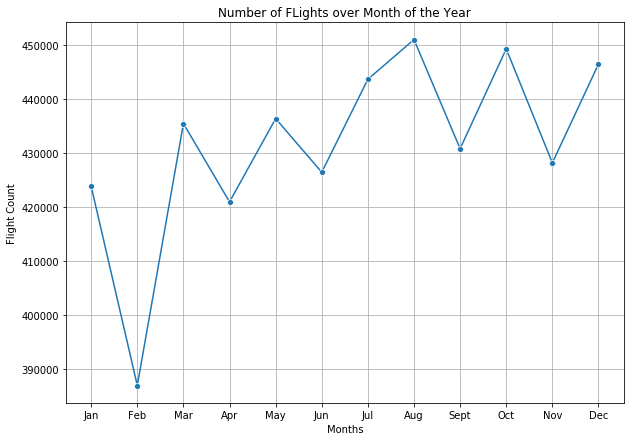

In [49]:
import seaborn as sn

plt.figure(figsize=(10,7))
plt.grid(True)
sns.lineplot(data=pandasDF, x='month', y="count", sort = False, marker='o')
plt.ylabel("Flight Count")
plt.xlabel("Months")
plt.title("Number of FLights over Month of the Year")
plt.show()




<div class="alert alert-success">

<b> ANSWER: </b> <br>
At the end we have

|index | Month | Count 
|------|-------|-------
|1| Jan   | 423861
|2| Feb   | 386954
|3| Mar   | 435516
|4| Apr   | 420995
|5| May   | 436432
|6| Jun   | 426490
|7| Jul   | 443736
|**8**| **Aug**   | **451086**
|9| Sep   | 430861
|10| Oct   | 449369
|11| Nov   | 428227
|12| Dec   | 446521

<br>

We have a **Pick** in **August, October** and **December** <br>
and a **Fall** in **February**
<br>

From the graph it is possible to notice an overall increasing of the num. of flights from Jan to December. 
<br>
The delay caused by the overall amount of flights is expected mostly in the last part of the year (with a big consideration of August). The other way around for the beginning of the year.

</div>


### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [108]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [109]:
df.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|
|1994|    1|          11|          2|                     900|                  1003|           88|     290|        CLT|         ORF|     US|
|1994|

In [110]:
month_week_count = df.groupBy('month','day_of_week').count().sort('month','day_of_week').toPandas()
week_count = df.groupBy('day_of_week').count().sort('day_of_week').toPandas()

In [111]:
week = ['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun']
month_week_count.day_of_week  = [week[int(i)-1] for i in month_week_count.day_of_week]

In [112]:
month_week_count.month  = [month[int(i)-1] for i in month_week_count.month]

In [113]:
month_week_count.head()

,month,day_of_week,count
0,Jan,Mon,70761
1,Jan,Tue,56327
2,Jan,Wen,55944
3,Jan,Thu,55870
4,Jan,Fri,56041


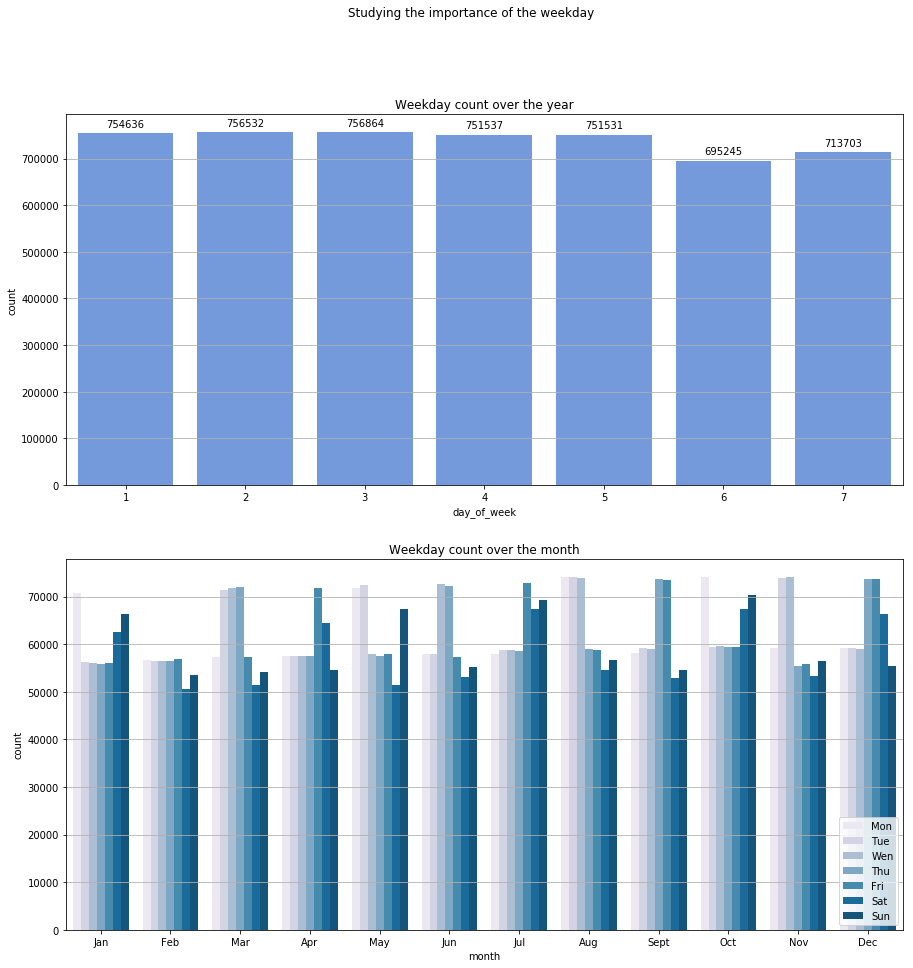

In [127]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

fig.suptitle('Studying the importance of the weekday')

# First Plot
ax1.grid(True)
ax1.set_title('Weekday count over the year')

sns.barplot(data=week_count,
            x='day_of_week',
            y='count', 
            ax = ax1, 
            color = 'cornflowerblue')

for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + 2e4, 
            f'{height:1.0f}', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment

# Second Plot
ax2.grid(True)
ax2.set_title('Weekday count over the month')
g = sns.barplot(data = month_week_count,
                x='month',
                y='count',
                hue='day_of_week',
                ax = ax2, 
                color = 'cornflowerblue',
                palette='PuBu',
                )

plt.legend(loc='lower right')
plt.show()

<div class="alert alert-success">
    
**Answer:**


**First Plot**

From the first plot is possbile to notice that at the beginning of the week we have an overall constant number of flights, arount 75000. This number decreases in the weekend.

**Second Plot**
Much more useful is the second plot where it is possible to througly understand the differences w.r.t the number of flights per days.

| Month | Most Flights | 
|-------|--------------|
| Jan   | Mon-Sun 
| Feb   | equal 
| Mar   | Tue/Thu 
| Apr   | Fri-Sat 
| May   | Sun/Tue 
| Jun   | Wen-Thu 
| Jul   | weekend 
| Aug   | Mon/Wen 
| Sep   | Thu-Fri 
| Oct   | Sat/Mon 
| Nov   | Mon-Wen 
| Dec   | Thu/Sat 


Indeed, the weekend does not always have the lower amount of flights (July, October).

Having said that, in general there is high variation probably caused by vacation, saison, etc...
    
</div>

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

#### Different Days

In [115]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [116]:
day_month_count = df.groupBy('day_of_month').count().sort('day_of_month').toPandas()
day_month_month_count = df.groupBy('month','day_of_month').count().sort('month','day_of_month').toPandas()

In [117]:
day_month_count.head()

,day_of_month,count
0,1,169674
1,2,169829
2,3,168678
3,4,169399
4,5,168423


In [119]:
day_month_month_count.month  = [month[int(i)-1] for i in day_month_month_count.month]

day_month_month_count.head()

,month,day_of_month,count
0,Jan,1,12158
1,Jan,2,13579
2,Jan,3,14204
3,Jan,4,14183
4,Jan,5,14122


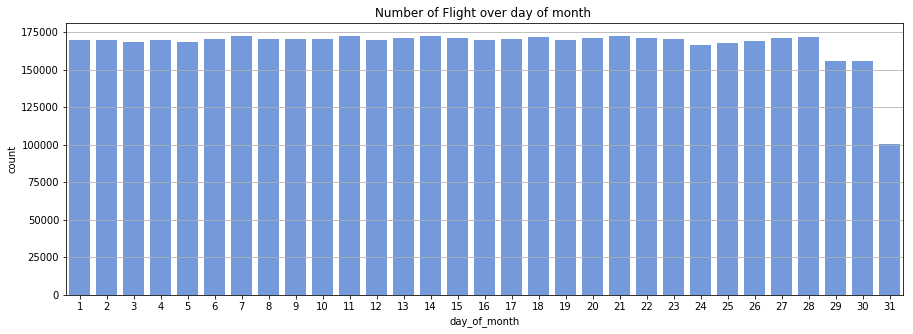

In [137]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

# First Plot
ax1.grid(True)
ax1.set_title('Number of Flight over day of month ')

sns.barplot(data=day_month_count,
            x='day_of_month',
            y='count', 
            ax = ax1, 
            color = 'cornflowerblue')

plt.show()

**Answer:**
<div class="alert alert-success"> 
From this graph we could say that 31 and 30 are the days with the least number of flights. However, we need to remember that only half of the month have the 31st and that in 1994 February had 28 days
</div>

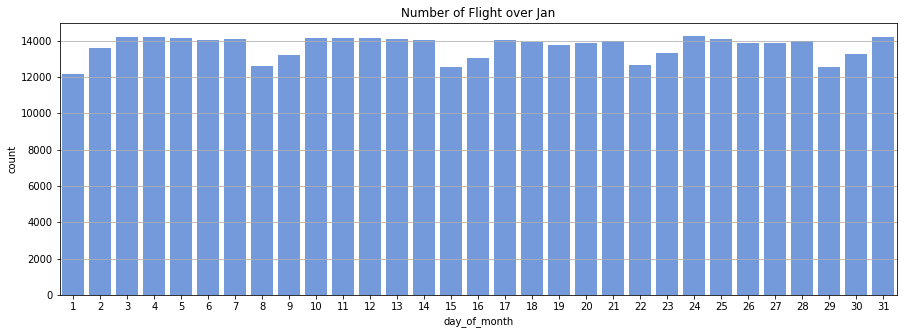

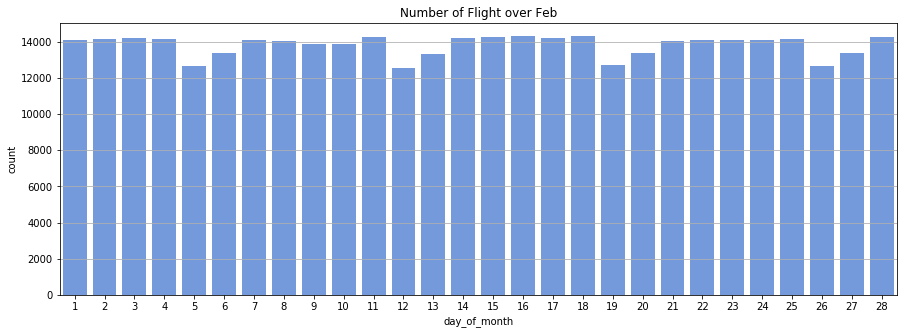

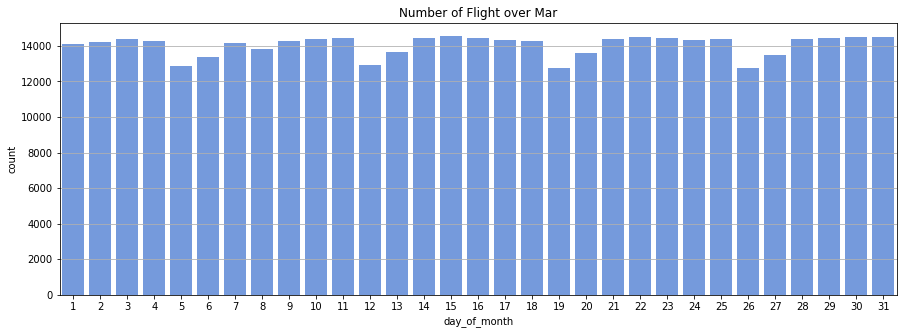

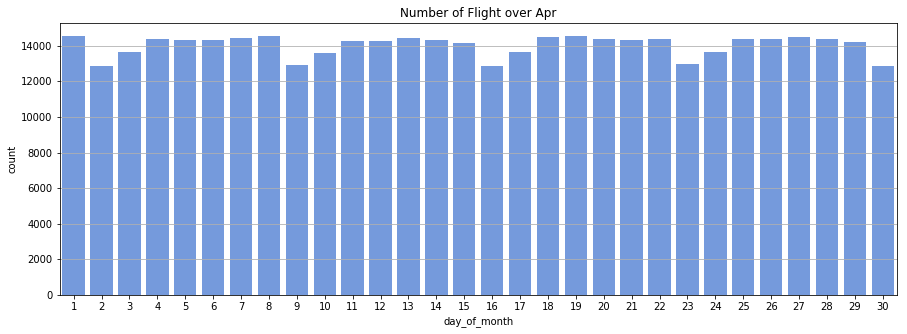

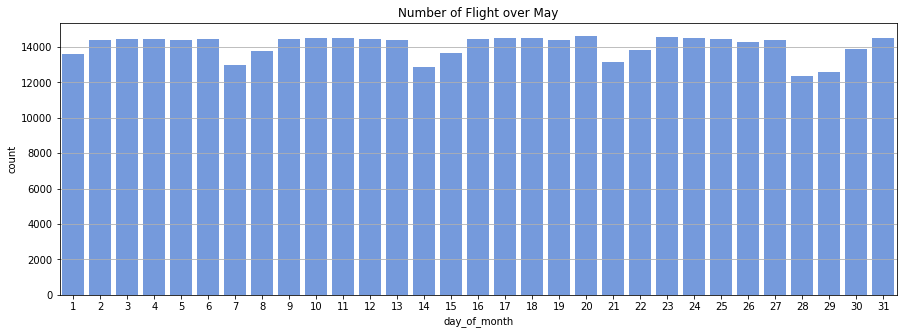

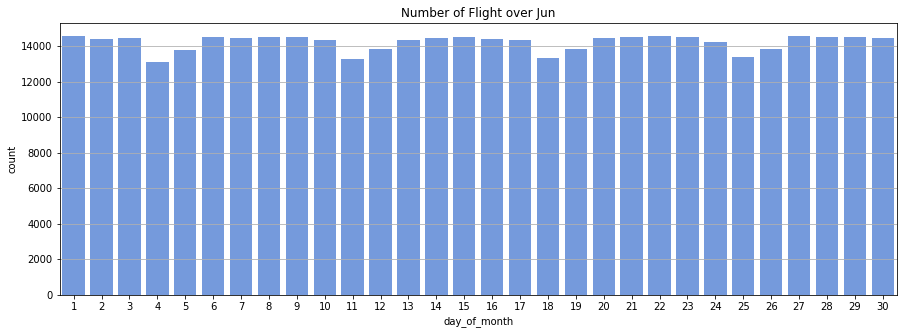

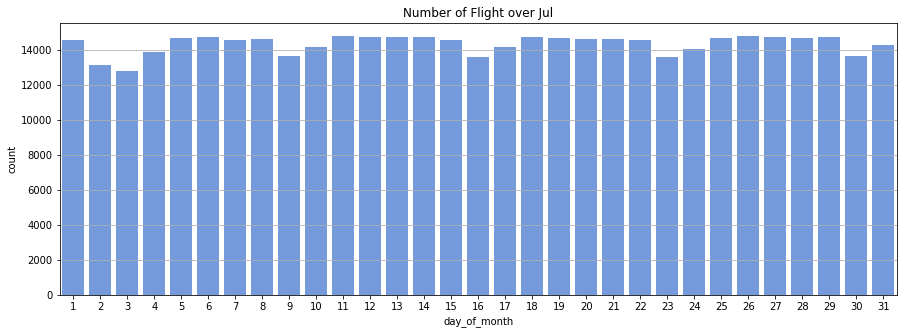

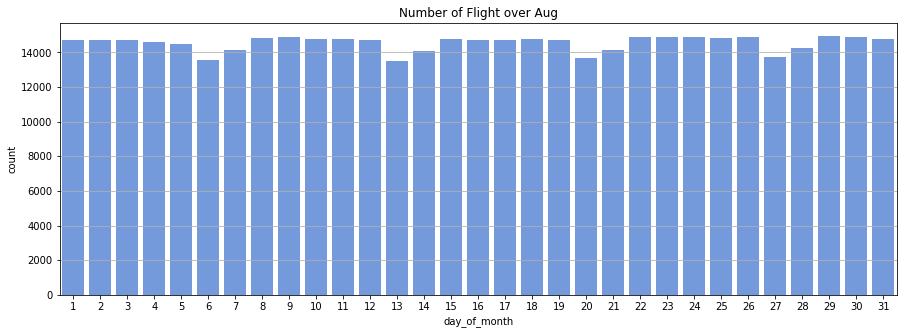

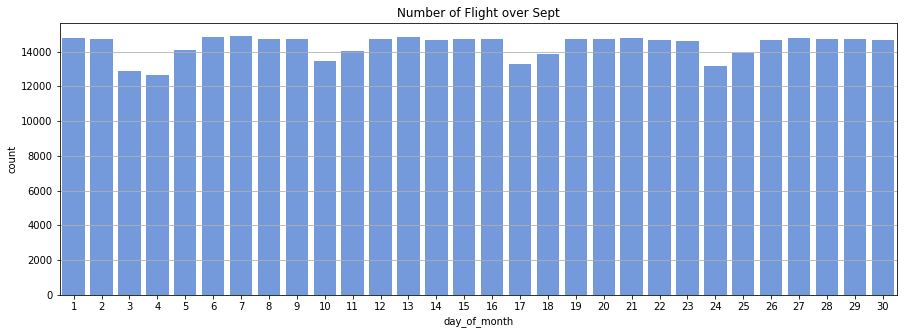

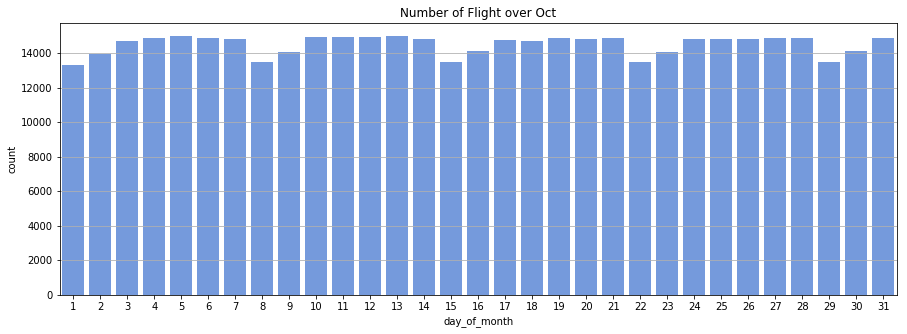

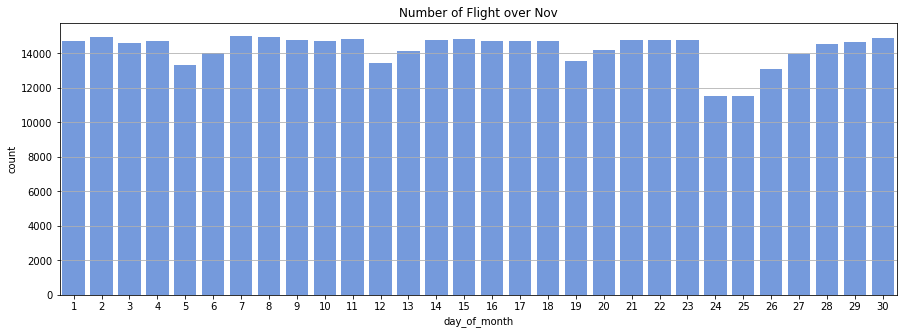

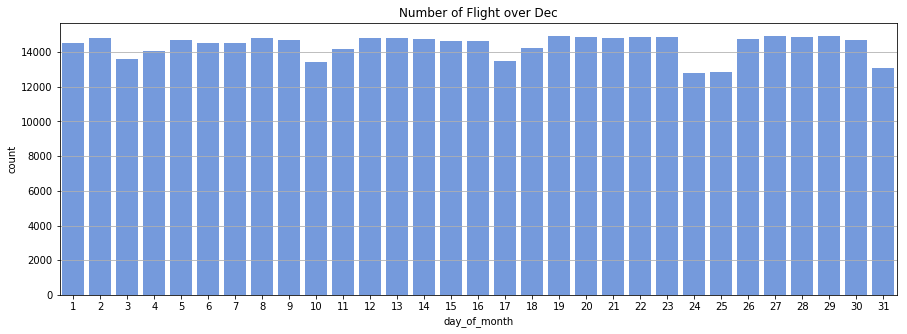

In [139]:
for i in range(12):
    pdf_monthly = day_month_month_count[day_month_month_count.month == month[i]]
    
    plt.figure(figsize=(15,5))
    plt.grid(True)
    plt.title(f"Number of Flight over {month[i]}")
    plt.xlim(0, 15000) #Used otherwise unfair comparison 
    sns.barplot(data=pdf_monthly,
                    x='day_of_month',
                    y='count',  
                    color = 'cornflowerblue')
    plt.show()


**Answer:**
<div class="alert alert-success">
From these plots we can be more precise on the importance of the day of the month. In the previous general plot, there were almost no differences among days. However now we can see that this is not the case infact the distribution of the flights over the day per each month is different.
    
    
Interesting date are 24/25 December where the number of flights is lower wrt the other days.
</div>

#### Different Hours

We want the number of flights per hour. Then, I will consider the **scheduled_departure_time**!

In [140]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [4]:
df_hour = (df
           
            #create the column hour from scheduled_departure_time
            .withColumn('hour', ((df.scheduled_departure_time/100)%24).cast('int'))
           
            # Used multiple times
            .cache()

            )

df_hour.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|
|1994|    1|          11|          2|                     900|                  1003|           88|     290|        CL

In [146]:
pdf_hour_year = df_hour.groupby('hour').count().sort('hour').toPandas()

pdf_hour_year.head()

,hour,count
0,0,13642
1,1,12825
2,2,2842
3,3,564
4,4,486


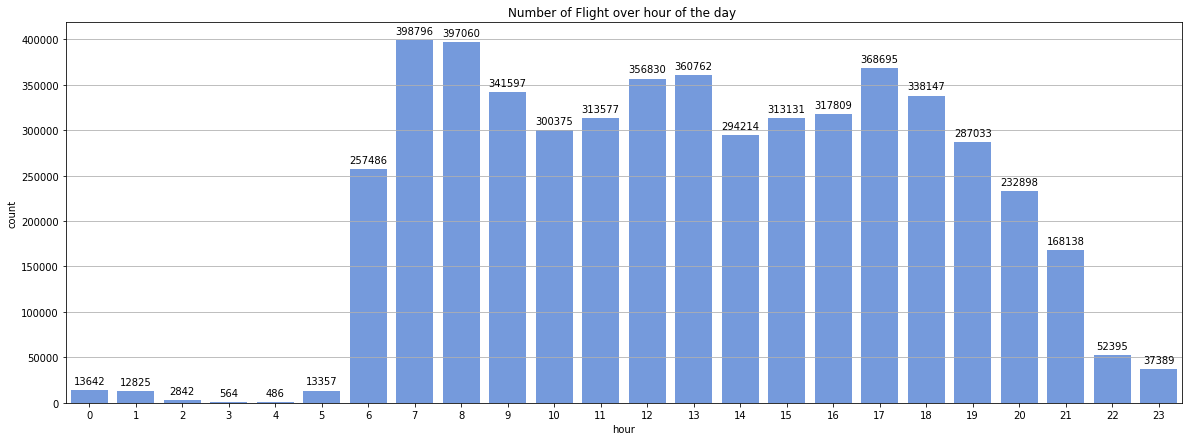

In [190]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,7))

# First Plot
ax1.grid(True)
ax1.set_title('Number of Flight over hour of the day ')

sns.barplot(data=pdf_hour_year,
            x='hour',
            y='count', 
            ax = ax1, 
            color = 'cornflowerblue')


for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + 1e4 , 
            '{:1.0f}'.format(height), # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment
    
    
    # p.get_y() + p.get_height() 
plt.show()

In [195]:
pdf_hour_month = df_hour.groupby('month','hour').count().sort('month','hour').toPandas()
pdf_hour_month.month  = [month[int(i)-1] for i in pdf_hour_month.month]

pdf_hour_month.head()

,month,hour,count
0,Jan,0,1154
1,Jan,1,901
2,Jan,2,238
3,Jan,3,62
4,Jan,4,33


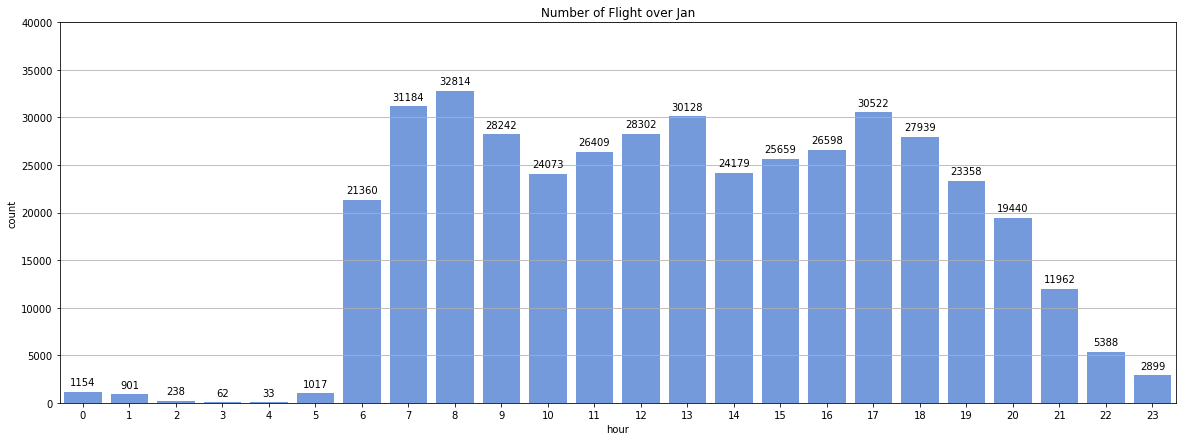

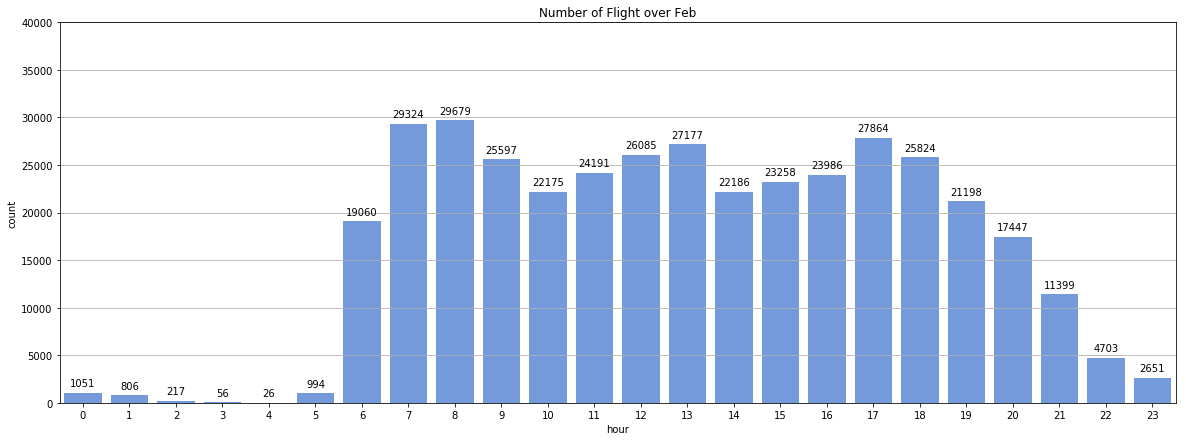

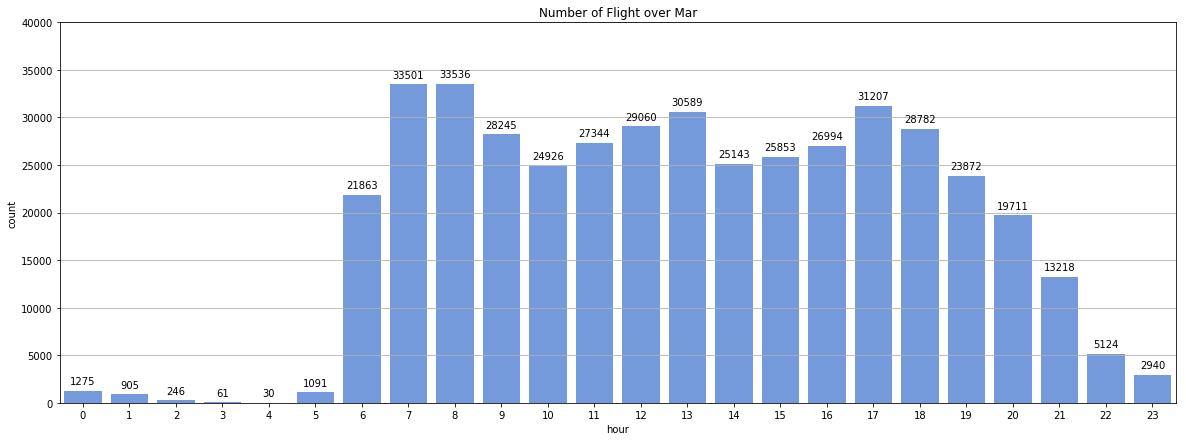

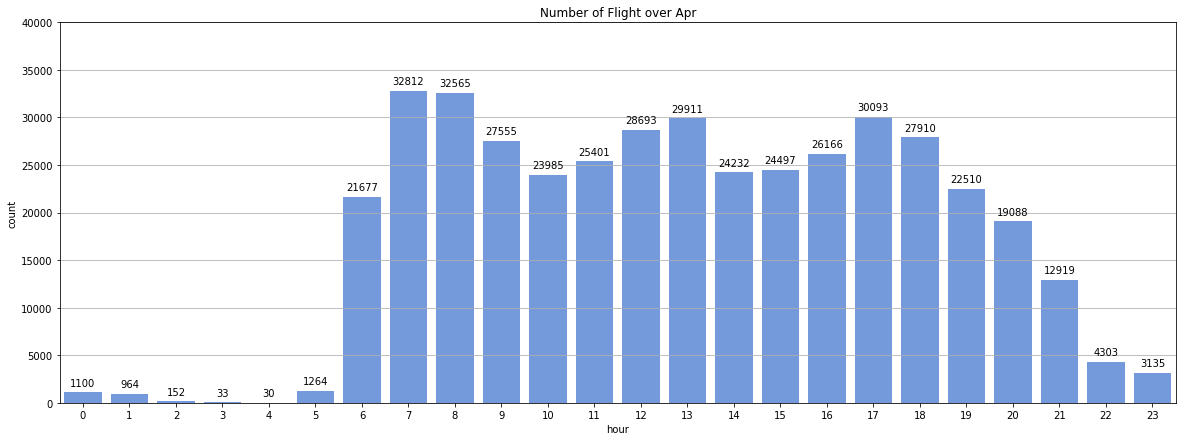

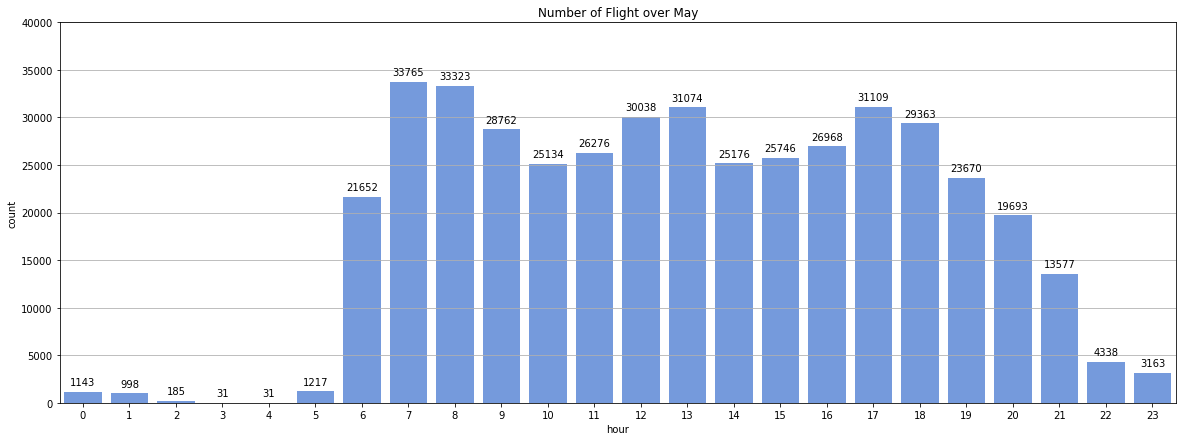

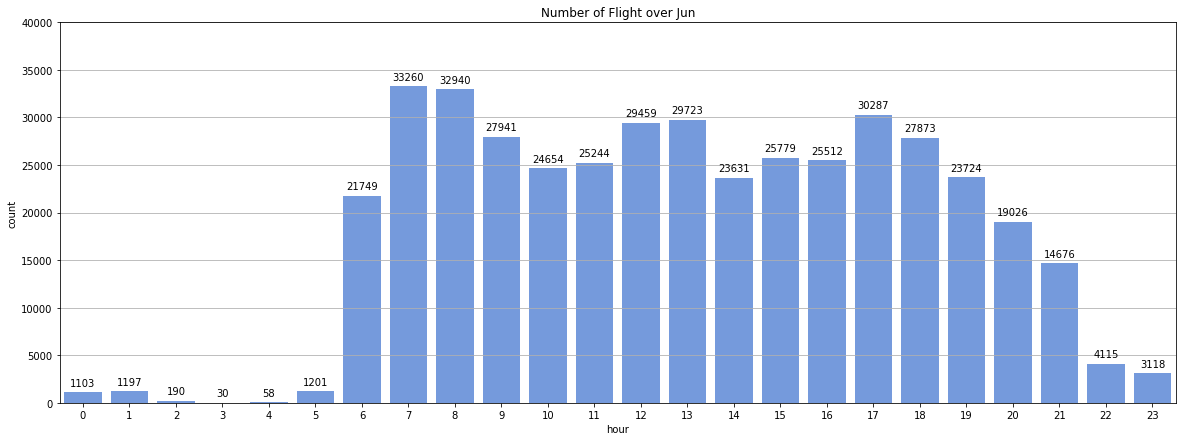

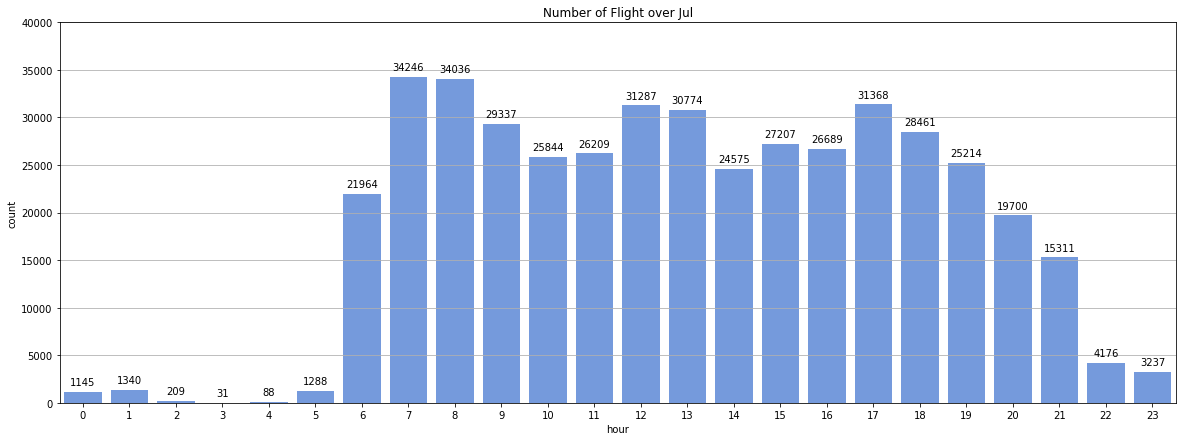

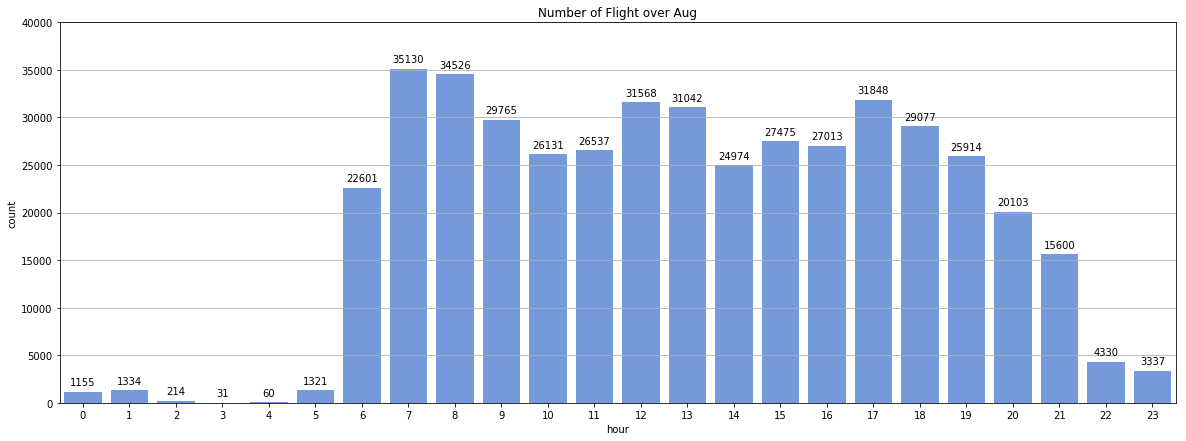

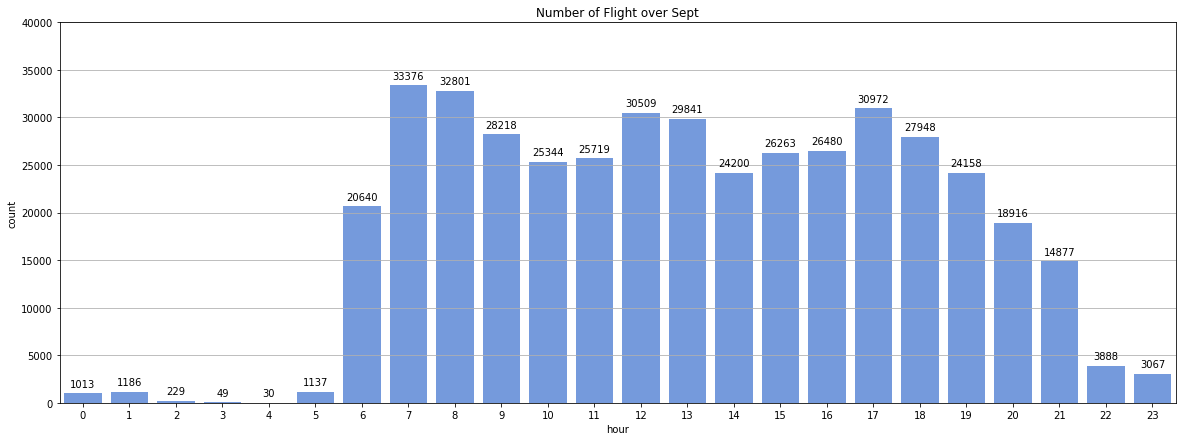

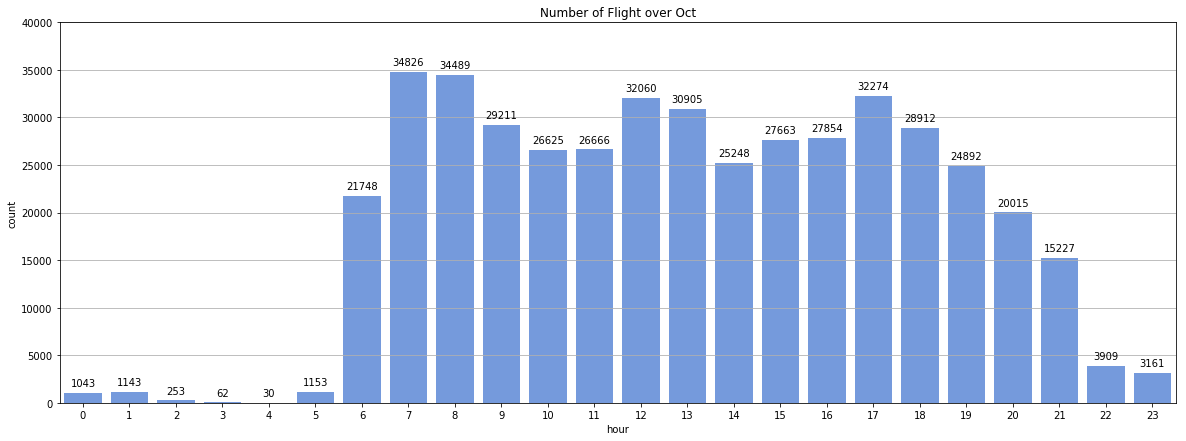

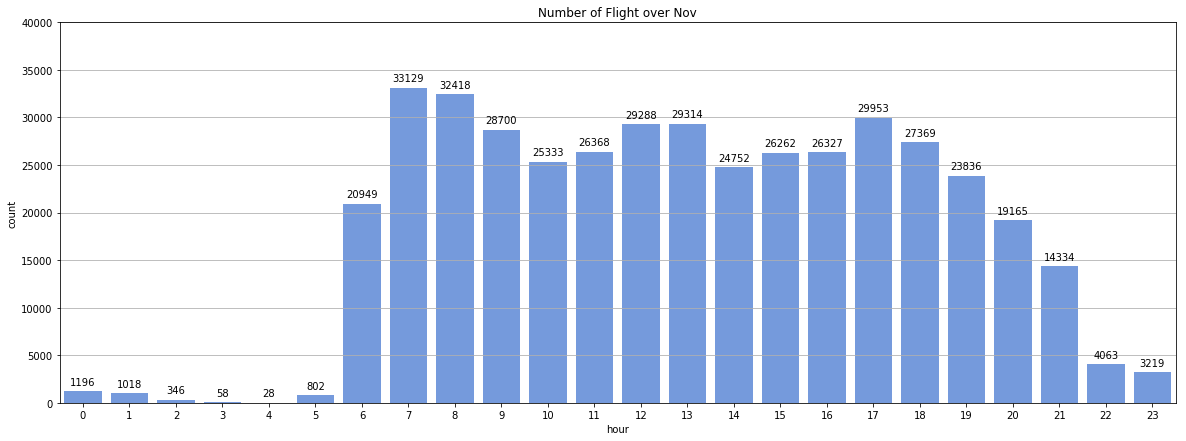

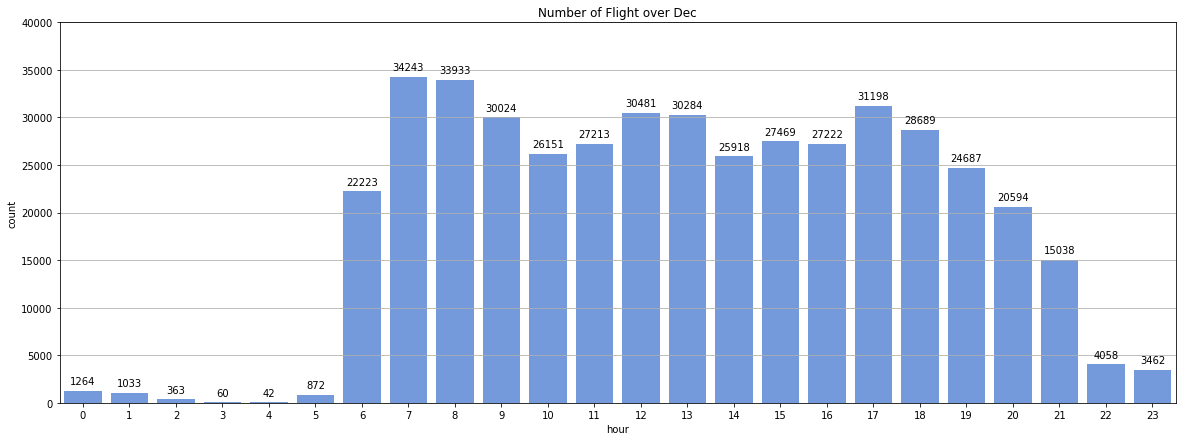

In [200]:
for i in range(12):
    
    pdf_monthly = pdf_hour_month[pdf_hour_month.month == month[i]]
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,7))
    
    #plt.figure(figsize=(20,7))
    plt.grid(True)
    plt.title(f"Number of Flight over {month[i]}")
    plt.ylim(0, 40000) #Used otherwise unfair comparison 
    sns.barplot(data=pdf_monthly,
                    x='hour',
                    y='count',  
                    color = 'cornflowerblue')
    
    for p in ax1.patches:
        height = p.get_height()    
        ax1.text(p.get_x() + p.get_width()/2, 
                height + 1e3 , 
                '{:1.0f}'.format(height), 
                ha = 'center',   
                va = 'center') 
    
    plt.show()

**Answer:**
<div class="alert alert-success">
From the global picture and the detailed one over each month, it is possible to notice that the trand is more or less the same.
    
-  Poor flight from 0:00am to 5:59am (almost none at 3/4am )
-  Increasing trand with a more or less stable amount of time between 6:00am to 6:00 pm
-  Decreasing trand until the end of the day

Possibility of delay:

-   7:00 -  8:00    
-  12:00 - 13:00
-  17:00 - 18:00

</div>

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [201]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



##### Inbounds

In [156]:
inboundsDF = (
            df.groupBy('src_airport').count()
                .sort(col('count').desc())
                .withColumnRenamed('count', 'count_inbound')
            )
inboundsDF.show(20)

+-----------+-------------+
|src_airport|count_inbound|
+-----------+-------------+
|        ORD|       277741|
|        DFW|       256274|
|        ATL|       221486|
|        LAX|       153494|
|        STL|       151609|
|        DEN|       141427|
|        PHX|       139581|
|        DTW|       136837|
|        PIT|       130977|
|        CLT|       129391|
|        MSP|       123222|
|        SFO|       118233|
|        EWR|       116768|
|        IAH|       104182|
|        LGA|       101864|
|        BOS|       100365|
|        LAS|        94972|
|        PHL|        93585|
|        DCA|        88445|
|        MCO|        77120|
+-----------+-------------+
only showing top 20 rows



##### Outbounds

In [157]:
outboundsDF = (
                df.groupBy('dest_airport')
                    .count()
                    .sort(col('count').desc())
                    .withColumnRenamed('count', 'count_outbound')
                )
outboundsDF.show(20)

+------------+--------------+
|dest_airport|count_outbound|
+------------+--------------+
|         ORD|        283720|
|         DFW|        260249|
|         ATL|        221588|
|         LAX|        152959|
|         STL|        152800|
|         DEN|        144099|
|         PHX|        140979|
|         DTW|        139435|
|         PIT|        131962|
|         CLT|        130321|
|         MSP|        124758|
|         SFO|        117245|
|         EWR|        117223|
|         IAH|        104409|
|         LGA|        101498|
|         BOS|         99331|
|         LAS|         94948|
|         PHL|         93312|
|         DCA|         87670|
|         MCO|         76600|
+------------+--------------+
only showing top 20 rows



##### Flights

In [158]:
busiest_airport = (inboundsDF.join(outboundsDF,
                                    inboundsDF.src_airport == outboundsDF.dest_airport,
                                    'outer')
          .withColumn('SUM', col('count_inbound') + col('count_outbound'))
          .withColumnRenamed('src_airport', 'airport')
          .select('airport','SUM')
          .sort(col('SUM').desc())
    )

busiest_airport.show(20)

pdf_busiest_airport = busiest_airport.toPandas().iloc[:20][:]

+-------+------+
|airport|   SUM|
+-------+------+
|    ORD|561461|
|    DFW|516523|
|    ATL|443074|
|    LAX|306453|
|    STL|304409|
|    DEN|285526|
|    PHX|280560|
|    DTW|276272|
|    PIT|262939|
|    CLT|259712|
|    MSP|247980|
|    SFO|235478|
|    EWR|233991|
|    IAH|208591|
|    LGA|203362|
|    BOS|199696|
|    LAS|189920|
|    PHL|186897|
|    DCA|176115|
|    MCO|153720|
+-------+------+
only showing top 20 rows



In [214]:
pdf_busiest_airport

,airport,SUM
0,ORD,561461.0
1,DFW,516523.0
2,ATL,443074.0
3,LAX,306453.0
4,STL,304409.0
5,DEN,285526.0
6,PHX,280560.0
7,DTW,276272.0
8,PIT,262939.0
9,CLT,259712.0


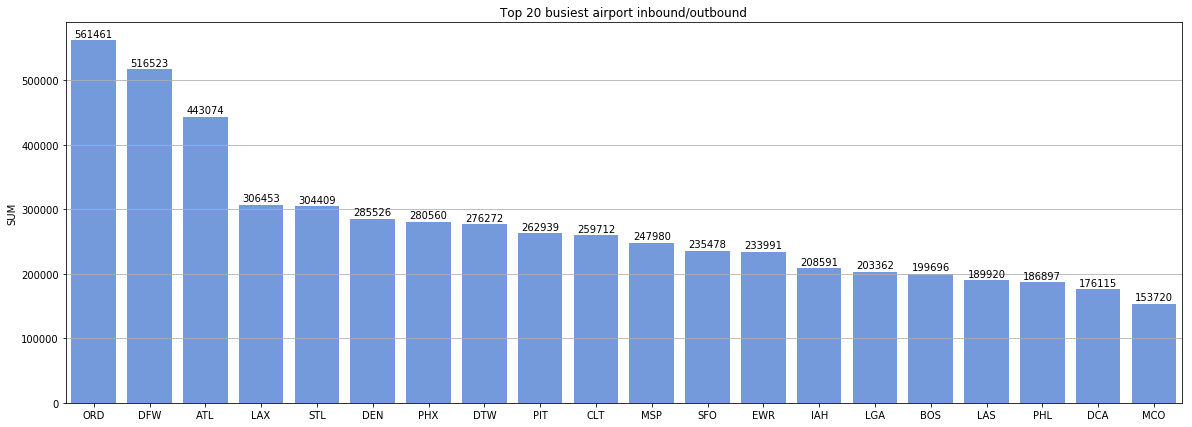

In [215]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,7))

# First Plot
ax1.grid(True)
ax1.set_title('Top 20 busiest airport inbound/outbound')

sns.barplot(data=pdf_busiest_airport,
            x='airport',
            y='SUM', 
            ax = ax1, 
            color = 'cornflowerblue')


for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + 1e4 , 
            '{:1.0f}'.format(height), # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment
    
    
plt.xlabel('')
plt.show()

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [216]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [241]:
busiest_carrier = df.groupBy('carrier').count().sort(col('count').desc()).limit(20).cache()

busiest_carrier.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



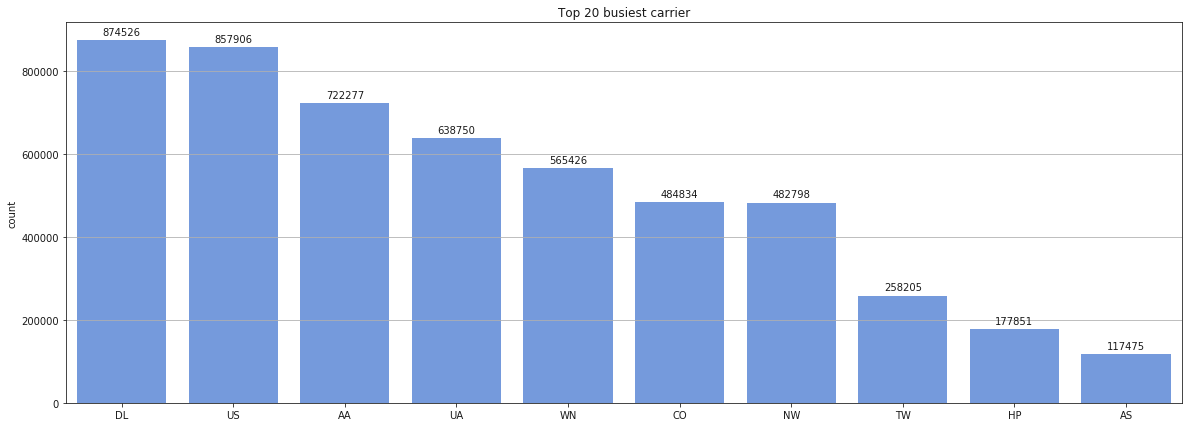

In [242]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,7))

# First Plot
ax1.grid(True)
ax1.set_title('Top 20 busiest carrier')

sns.barplot(data=busiest_carrier.toPandas(),
            x='carrier',
            y='count', 
            ax = ax1, 
            color = 'cornflowerblue')


for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + 2e4 , 
            '{:1.0f}'.format(height), # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment
    
    
plt.xlabel('')
plt.show()

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [53]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [54]:
# I will use this dataframe cached in the previous cells
df_hour.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|
|1994|    1|          11|          2|                     900|                  1003|           88|     290|        CL

In [55]:
from pyspark.sql.functions import lit

df_hour_delay = (df_hour
                       
                        # map 1 if delay 0 otherwise
                       .withColumn('is_delay', func.when(df_hour.arrival_delay >= 15, 1).otherwise(0))
                       
                       #used multiple times
                       .cache()
              )

df_hour_delay.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|is_delay|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|       1|
|1994|    1|          11|          2|                     900|  

In [56]:
df_hour_delay_percent = (
                         df_hour_delay
                                      .groupby('hour').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('hour', ascending=1)
                        )

df_hour_delay_percent.show(5)

+----+------------------+
|hour|        percentage|
+----+------------------+
|   0| 17.09426770268289|
|   1|14.838206627680313|
|   2| 5.348346235045742|
|   3|1.5957446808510638|
|   4|   5.1440329218107|
+----+------------------+
only showing top 5 rows



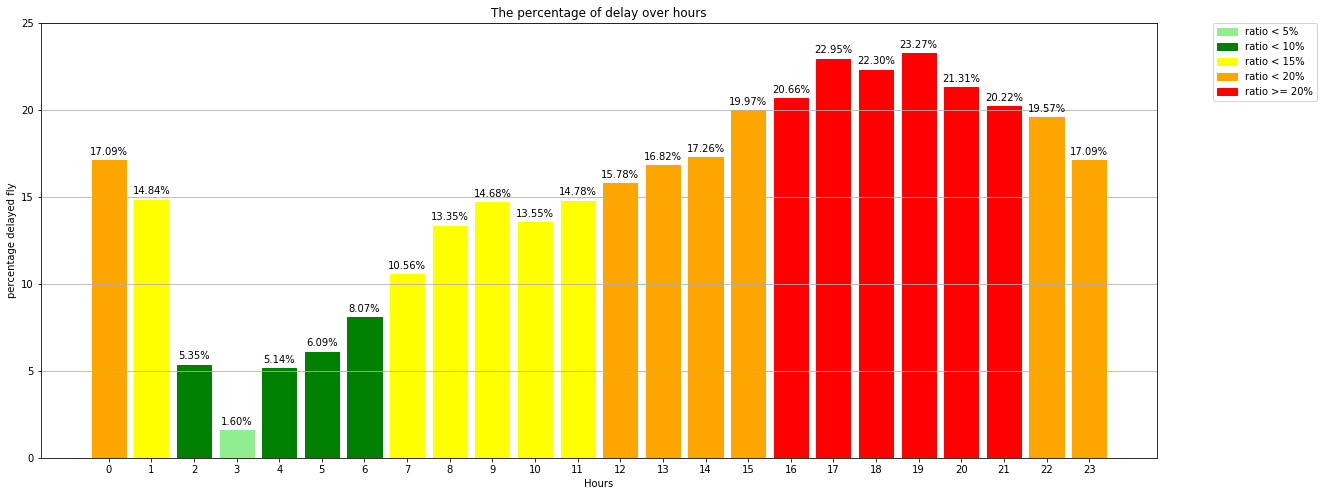

In [138]:
pdf = df_hour_delay_percent.toPandas()

plt.figure(figsize=(20,8))
plt.xlabel('Hours')
plt.ylabel("percentage delayed fly")
plt.title(f'The percentage of delay over hours')
plt.grid(False, which='both')

bars = plt.bar( pdf['hour'], pdf['percentage'], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf.iloc[i, 1] < 5:
        color = 'lightgreen'
    elif pdf.iloc[i, 1] < 10:
        color = 'green'
    elif pdf.iloc[i, 1] < 15:
        color = 'yellow'
    elif pdf.iloc[i, 1] < 20:
        color = 'orange'

    bars[i].set_color(color)

patch1 = mpatches.Patch(color='lightgreen', label='ratio < 5%')
patch2 = mpatches.Patch(color='green', label='ratio < 10%')
patch3 = mpatches.Patch(color='yellow', label='ratio < 15%')
patch4 = mpatches.Patch(color='orange', label='ratio < 20%')
patch5 = mpatches.Patch(color='red', label='ratio >= 20%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(range(24))
plt.ylim(0, 25)
plt.margins(0.05, 0)

ax1 = plt.gca()
ax1.grid(axis='y')
for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + .5 , 
            f'{height:1.2f}%', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment
    

**Answer:**
<div class="alert alert-success">
From the previous results we could expect the percentage of delayed flight over hours. Indeed, the highest percentages are not from 2am to 6am (lower number of flghts means also lower delayed flight)
</div>

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [65]:
df_delay_avg = (df_hour
                        .groupby('hour').avg('arrival_delay')
                        .orderBy('hour')
)

df_delay_avg.show(5)

+----+-------------------+
|hour| avg(arrival_delay)|
+----+-------------------+
|   0|  4.631536068730559|
|   1| 2.7302062017944277|
|   2|-2.7850566572237963|
|   3|-2.7652329749103943|
|   4|0.29583333333333334|
+----+-------------------+
only showing top 5 rows



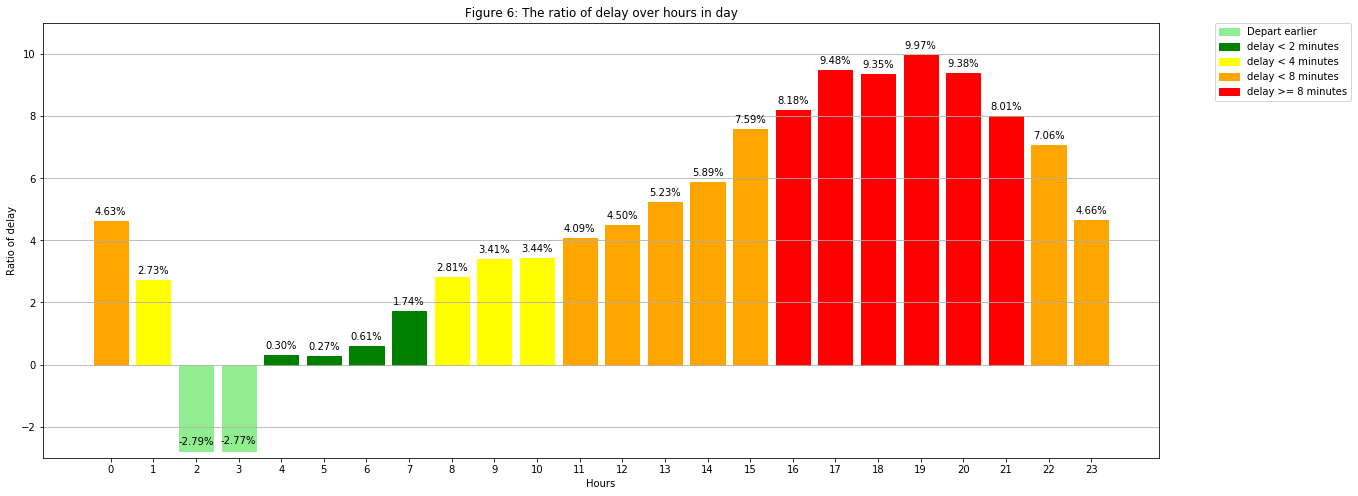

In [141]:
pdf_mean_delay_per_hour = pd.DataFrame(data=df_delay_avg.collect())

plt.figure(figsize=(20,8))

plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The ratio of delay over hours in day')
plt.ylim(-3, 11)
plt.xticks(range(24))

bars = plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)

ax1 = plt.gca()
ax1.grid(axis='y')
for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + .3 , 
            f'{height:1.2f}%', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [75]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [76]:
df_hour_delay.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|is_delay|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|       1|
|1994|    1|          11|          2|                     900|  

In [77]:
df_delay_over_month = (
                         df_hour_delay
                                      .groupby('day_of_month').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('day_of_month', ascending=1)
                        )

df_delay_over_month.show(5)

+------------+------------------+
|day_of_month|        percentage|
+------------+------------------+
|           1|14.879121138182633|
|           2|15.071630875763267|
|           3|14.854337850816348|
|           4|14.438692082007568|
|           5| 16.99233477612915|
+------------+------------------+
only showing top 5 rows



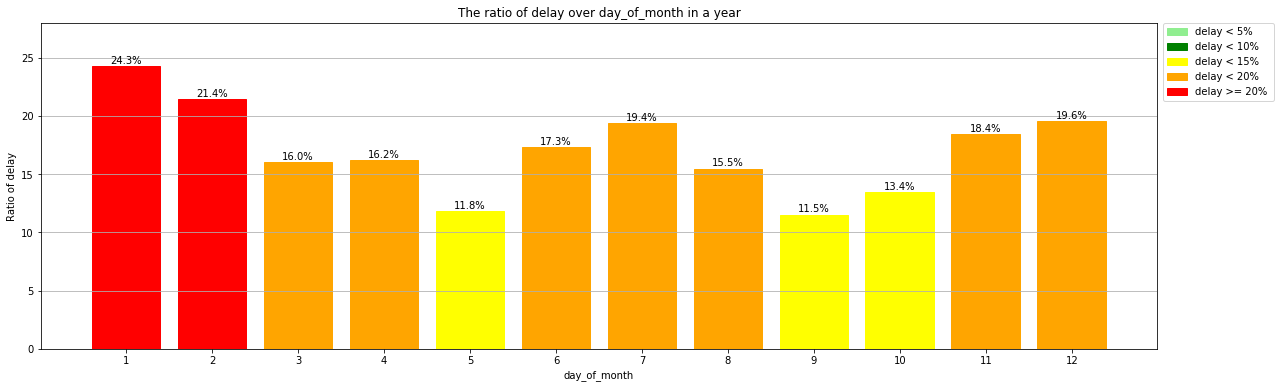

In [144]:
pdf = pd.DataFrame(data=df_delay_over_month.collect())

plt.figure(figsize=(20,6))

plt.xlabel("day_of_month")
plt.ylabel("Ratio of delay")
plt.title('The ratio of delay over day_of_month in a year')

plt.ylim(0, 28)
plt.xticks(range(32))

bars = plt.bar(pdf[0], pdf[1], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf[1][i] < 5:
        color = 'lightgreen'
    elif pdf[1][i] < 10:
        color = 'green'
    elif pdf[1][i] < 15:
        color = 'yellow'
    elif pdf[1][i] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15% ')
patch4 = mpatches.Patch(color='orange', label='delay < 20% ')
patch5 = mpatches.Patch(color='red', label='delay >= 20% ')

ax1 = plt.gca()
ax1.grid(axis='y')
for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + .5 , 
            f'{height:1.1f}%', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

<div class="alert alert-success">
    
**Answer:**

Globally in a year we can see that almost every day there is an high percentage of delay ( >15% ). However, since we have seen that the global statistic is not always representative, I will also plot the statistics for each month
</div>


In [145]:
def plot_day_over_month(pdf, month, x_title):

    plt.figure(figsize=(20,6))

    plt.xlabel(x_title)
    plt.ylabel("Ratio of delay")
    plt.title(f'The ratio of delay over day_of_month in {month}')
   
    plt.ylim(0, 50)
    plt.xticks(range(1,32))

    bars = plt.bar(pdf.iloc[:,0], pdf.iloc[:,1], align='center', edgecolor = "black")

    for i in range(0, len(bars)):
        color = 'red'
        if pdf.iloc[i,1] < 5:
            color = 'lightgreen'
        elif pdf.iloc[i,1] < 10:
            color = 'green'
        elif pdf.iloc[i,1] < 15:
            color = 'yellow'
        elif pdf.iloc[i,1] < 20:
            color = 'orange'

        bars[i].set_color(color)

    patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
    patch2 = mpatches.Patch(color='green', label='delay < 10%')
    patch3 = mpatches.Patch(color='yellow', label='delay < 15% ')
    patch4 = mpatches.Patch(color='orange', label='delay < 20% ')
    patch5 = mpatches.Patch(color='red', label='delay >= 20% ')
    
    ax1 = plt.gca()
    ax1.grid(axis='y')
    for p in ax1.patches:
        height = p.get_height()    # get bar length
        ax1.text(p.get_x() + p.get_width()/2, 
                height + 1 , 
                f'{height:1.1f}%', # set variable to display, 2 decimals
                ha = 'center',   # horizontal alignment
                va = 'center')  # vertical alignment

    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    plt.margins(0.05, 0)
    plt.show()
    

In [86]:
df_hour_delay.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|is_delay|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|       1|
|1994|    1|          11|          2|                     900|  

In [30]:
df_delay_per_month = (
                         df_hour_delay
                                      .groupby('month', 'day_of_month').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('month', 'day_of_month', ascending=1)
                        )

df_delay_per_month.show()

+-----+------------+------------------+
|month|day_of_month|        percentage|
+-----+------------+------------------+
|    1|           1|12.148379667708504|
|    1|           2|24.957655202886812|
|    1|           3|31.695297099408617|
|    1|           4|25.347246703800323|
|    1|           5| 32.09177170372468|
|    1|           6|31.660616413979643|
|    1|           7|24.381750994883458|
|    1|           8|16.342721142403807|
|    1|           9|19.655276685817963|
|    1|          10|19.565217391304348|
|    1|          11|20.041073578358475|
|    1|          12| 30.39672455174361|
|    1|          13| 25.43734888351586|
|    1|          14| 25.95180379295594|
|    1|          15|13.062200956937799|
|    1|          16| 27.64158918005072|
|    1|          17|30.650110611574966|
|    1|          18|  27.3498131647025|
|    1|          19|28.578687572590013|
|    1|          20|30.206230170175946|
+-----+------------+------------------+
only showing top 20 rows



In [15]:
pdf_mont_percnt = df_delay_per_month.toPandas()
pdf_mont_percnt.head()

,month,day_of_month,percentage
0,1,1,12.148380
1,1,2,24.957655
2,1,3,31.695297
3,1,4,25.347247
4,1,5,32.091772


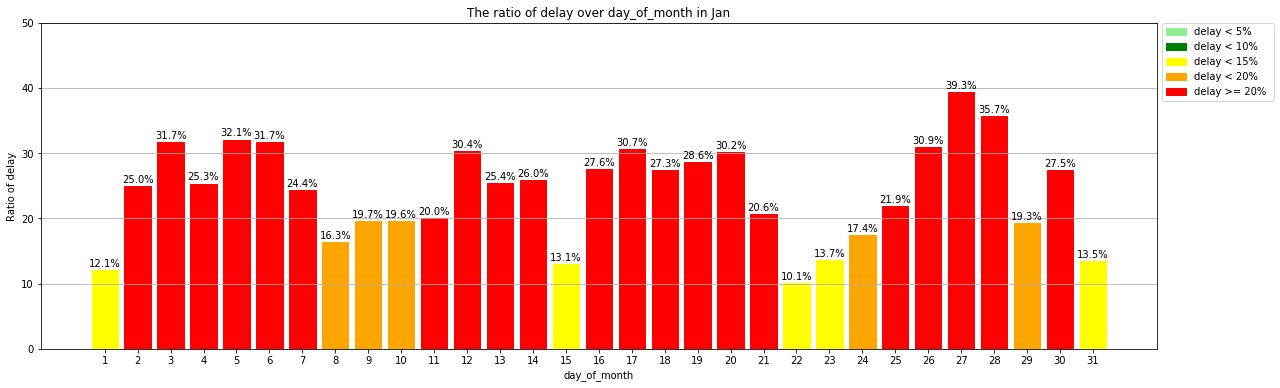

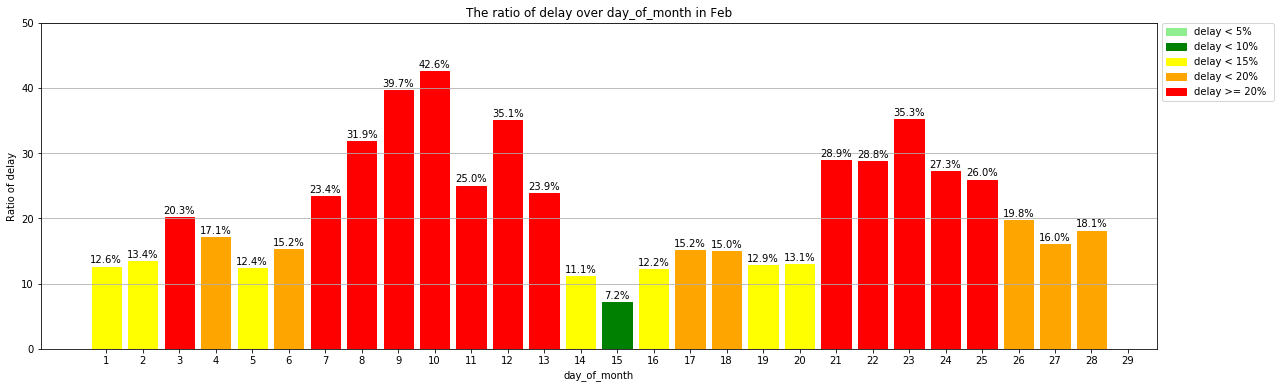

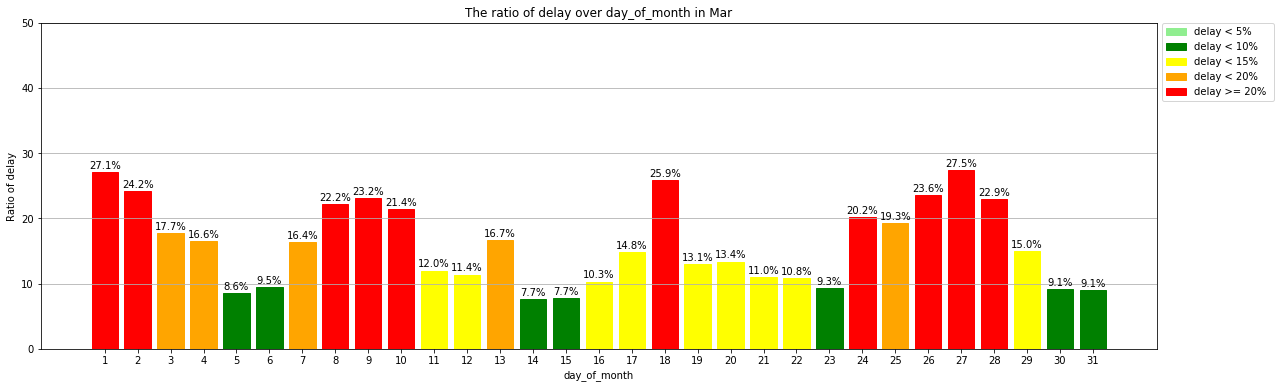

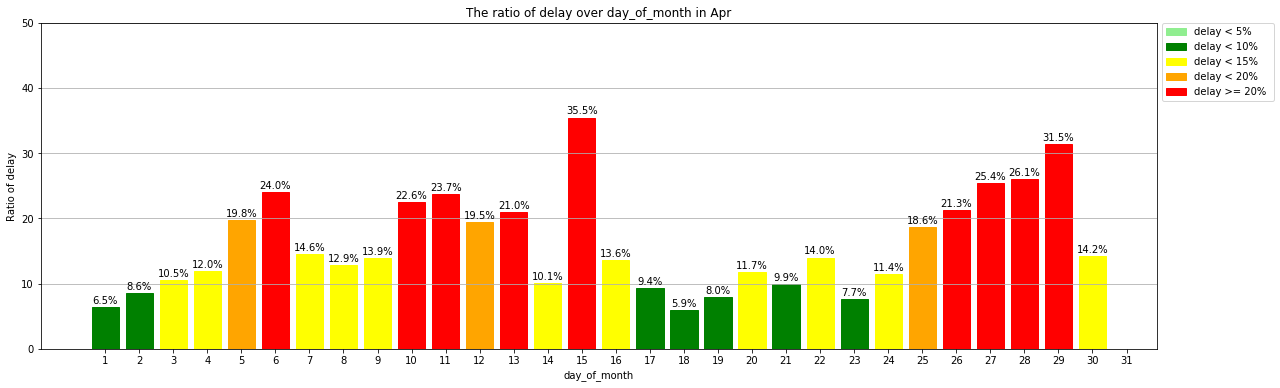

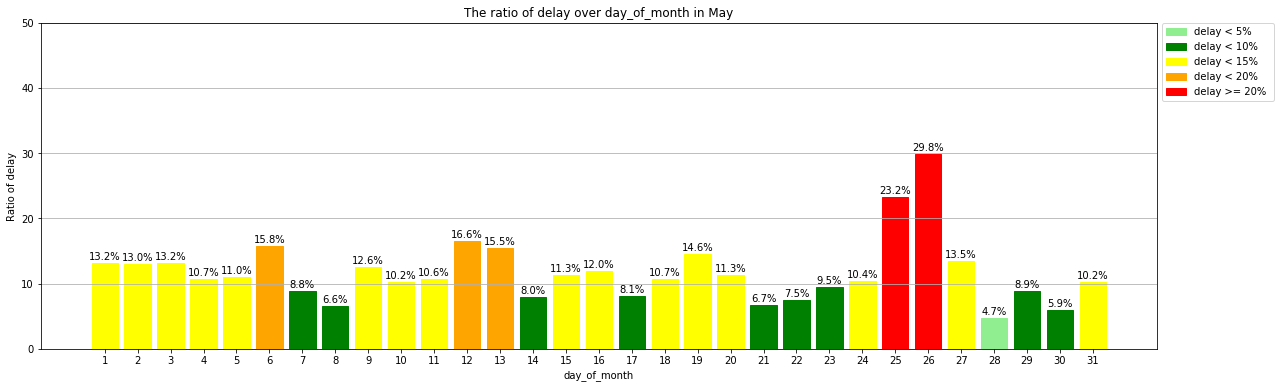

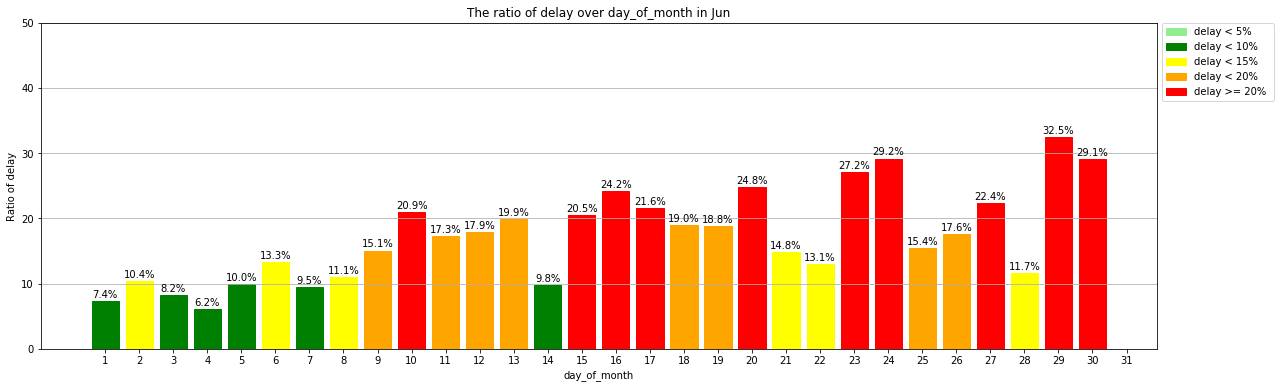

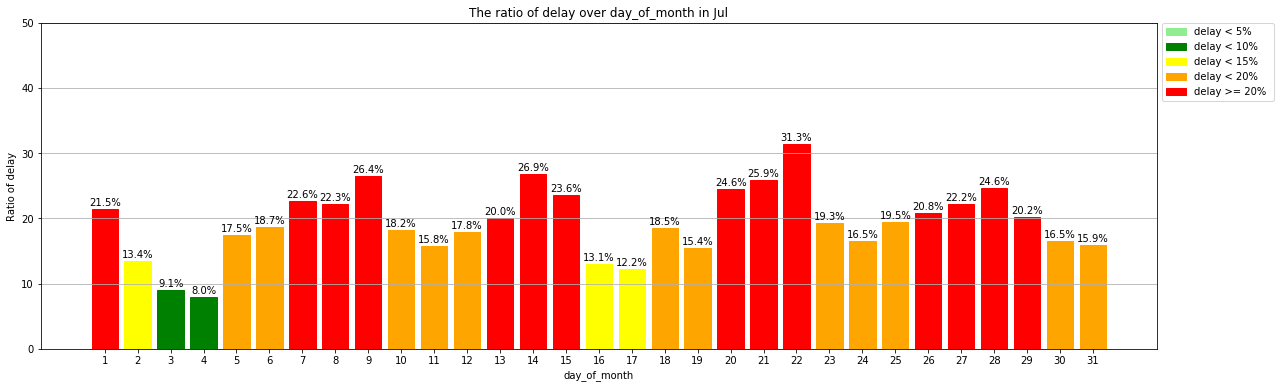

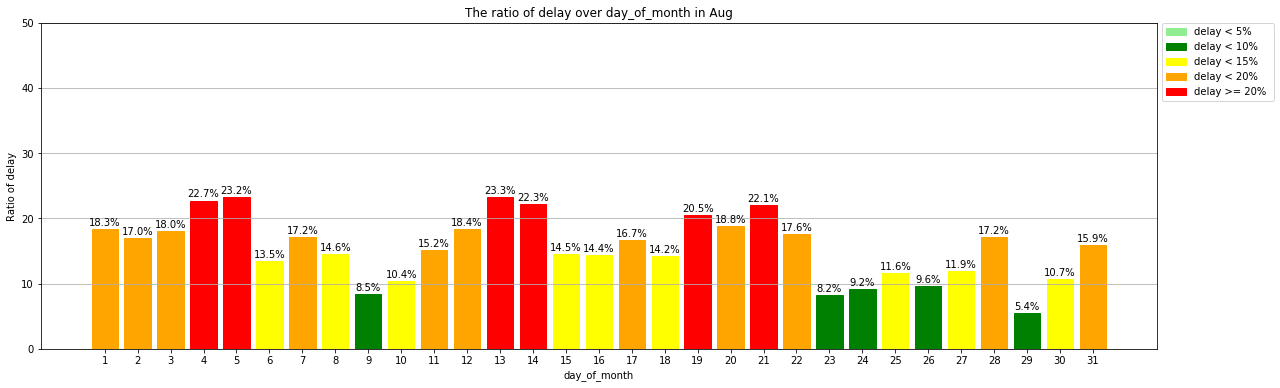

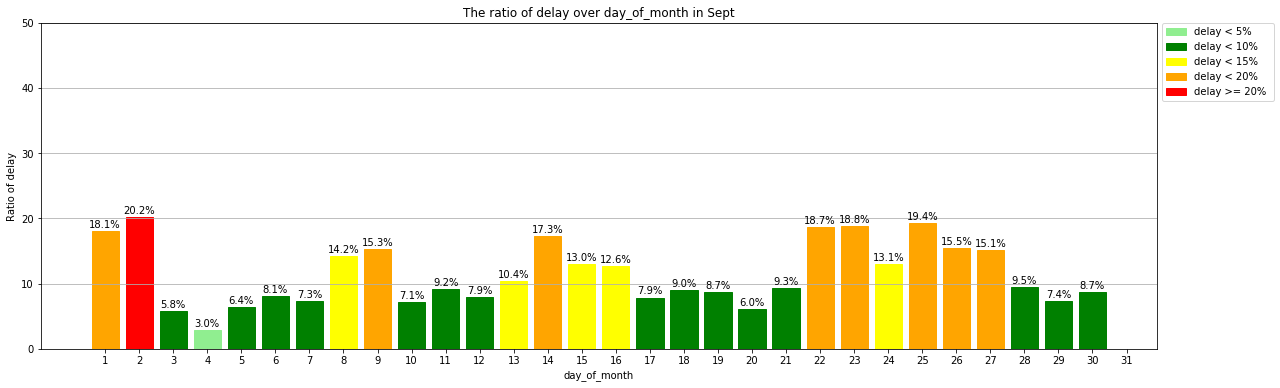

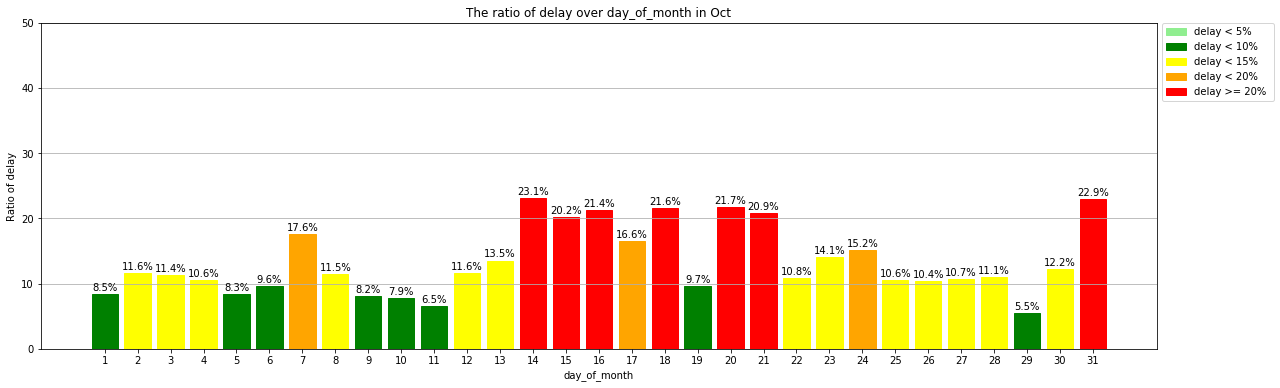

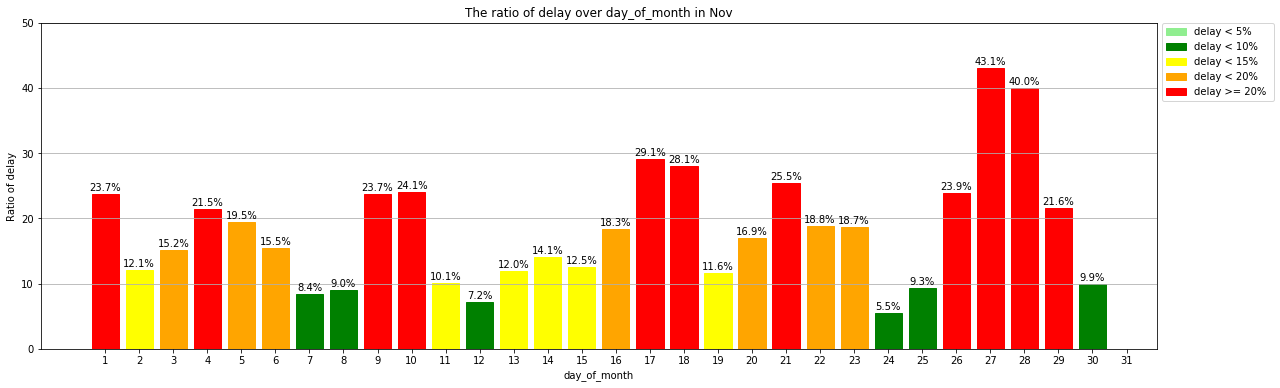

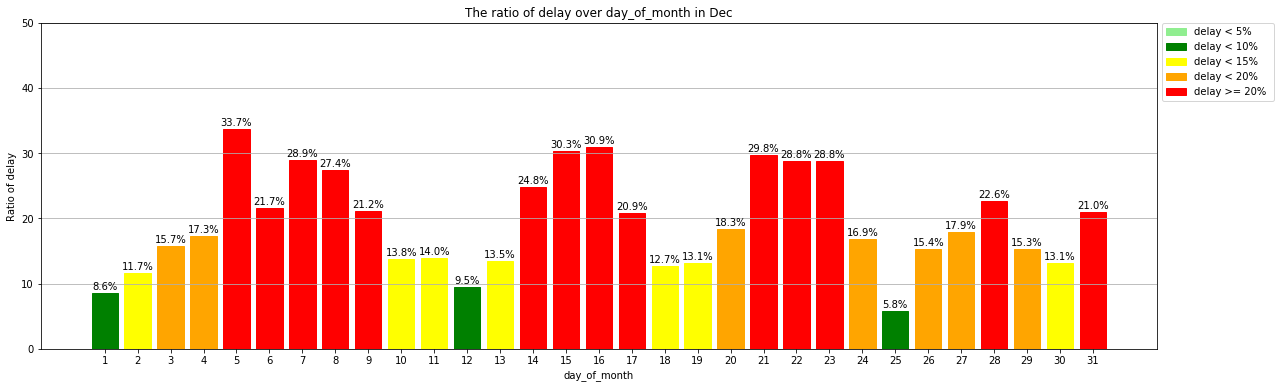

In [146]:
for i in range(1,13):
    pdf = pdf_mont_percnt[pdf_mont_percnt.month == i][['day_of_month','percentage']]
    
    plot_day_over_month(pdf, month[i-1], 'day_of_month')
    

**Answer:**
As was expected the percentage of delay for each month is quite different from the global statistics.

What I can see from the graph:

-  **Jannuary** is the **worst** month to fly. Almost all the days the more than 20% of the flight has a delay (with a pick of 40%)
-  **September** is the **best** month to fly with the overall lowest percentages
-  **27** and **28** are confirmed to be the worst days. Even if there are month with low percentages ( September ), they are compensate by the other months with a pick of over 40% (November)

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [90]:
df_delay_over_week = (
                         df_hour_delay
                                      .groupby('day_of_week').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('day_of_week', ascending=1)
                        )

df_delay_over_week.show(5)

+-----------+------------------+
|day_of_week|        percentage|
+-----------+------------------+
|          1|16.329197122851284|
|          2|15.330349542385518|
|          3|18.151213428039913|
|          4|19.779731403776527|
|          5|19.487020495495194|
+-----------+------------------+
only showing top 5 rows



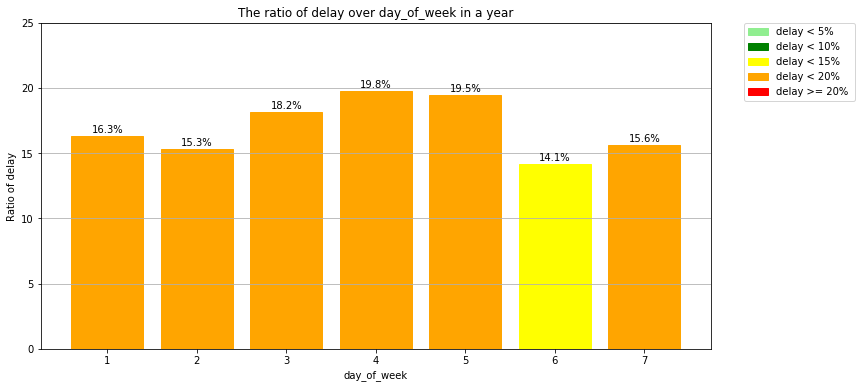

In [147]:
pdf = pd.DataFrame(data=df_delay_over_week.collect())

plt.figure(figsize=(12,6))

plt.xlabel("day_of_week")
plt.ylabel("Ratio of delay")
plt.title('The ratio of delay over day_of_week in a year')

plt.ylim(0, 25)
plt.xticks(range(32))

bars = plt.bar(pdf[0], pdf[1], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf[1][i] < 5:
        color = 'lightgreen'
    elif pdf[1][i] < 10:
        color = 'green'
    elif pdf[1][i] < 15:
        color = 'yellow'
    elif pdf[1][i] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15% ')
patch4 = mpatches.Patch(color='orange', label='delay < 20% ')
patch5 = mpatches.Patch(color='red', label='delay >= 20% ')

ax1 = plt.gca()
ax1.grid(axis='y')
for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + .5 , 
            f'{height:1.1f}%', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

**Answer:**

Globally the percentage of delay is always less than 20%. However, it is better to futher investigate for each month

In [148]:
def plot_day_over_week(pdf, month, x_title):

    plt.figure(figsize=(12,6))

    plt.xlabel(x_title)
    plt.ylabel("Ratio of delay")
    plt.title(f'The ratio of delay over day_of_week in {month}')
 
    plt.ylim(0, 35)
    plt.xticks(range(32))

    bars = plt.bar(week, pdf.iloc[:,1], align='center', edgecolor = "black")

    for i in range(0, len(bars)):
        color = 'red'
        if pdf.iloc[i,1] < 5:
            color = 'lightgreen'
        elif pdf.iloc[i,1] < 10:
            color = 'green'
        elif pdf.iloc[i,1] < 15:
            color = 'yellow'
        elif pdf.iloc[i,1] < 20:
            color = 'orange'

        bars[i].set_color(color)

    patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
    patch2 = mpatches.Patch(color='green', label='delay < 10%')
    patch3 = mpatches.Patch(color='yellow', label='delay < 15% ')
    patch4 = mpatches.Patch(color='orange', label='delay < 20% ')
    patch5 = mpatches.Patch(color='red', label='delay >= 20% ')
    
    ax1 = plt.gca()
    ax1.grid(axis='y')
    for p in ax1.patches:
        height = p.get_height()    # get bar length
        ax1.text(p.get_x() + p.get_width()/2, 
                height + .5 , 
                f'{height:1.1f}%', # set variable to display, 2 decimals
                ha = 'center',   # horizontal alignment
                va = 'center')  # vertical alignment

    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    plt.margins(0.05, 0)
    plt.show()
    

In [97]:
df_delay_week_month = (
                         df_hour_delay
                                      .groupby('month', 'day_of_week').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('month', 'day_of_week', ascending=1)
                        )

df_delay_week_month.show(5)

+-----+-----------+------------------+
|month|day_of_week|        percentage|
+-----+-----------+------------------+
|    1|          1|22.551970718333546|
|    1|          2| 23.63875228575994|
|    1|          3|30.503718003718003|
|    1|          4|31.639520315017005|
|    1|          5|26.673328455951893|
+-----+-----------+------------------+
only showing top 5 rows



In [98]:
pdf_week_percnt = df_delay_week_month.toPandas()

pdf_week_percnt.head(5)

,month,day_of_week,percentage
0,1,1,22.551971
1,1,2,23.638752
2,1,3,30.503718
3,1,4,31.639520
4,1,5,26.673328


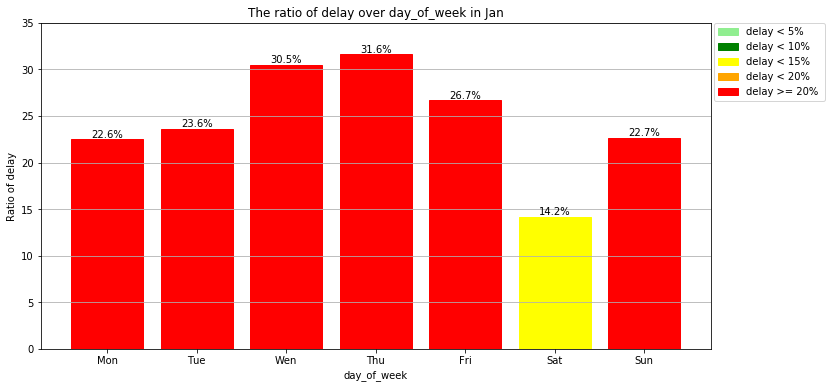

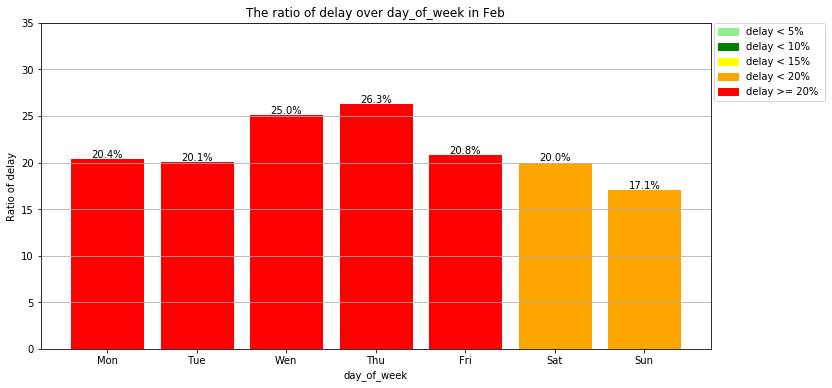

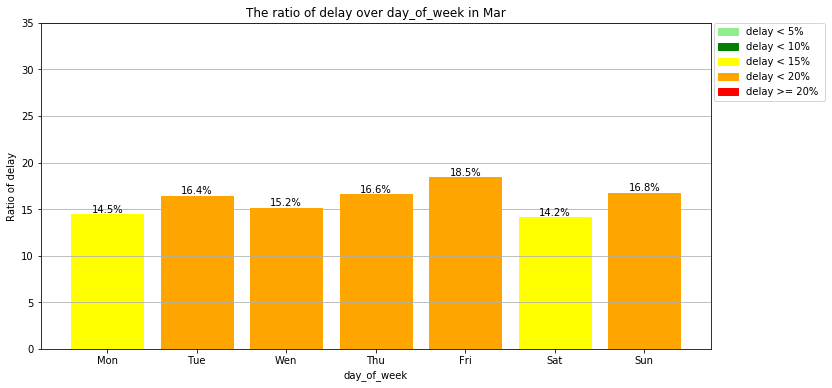

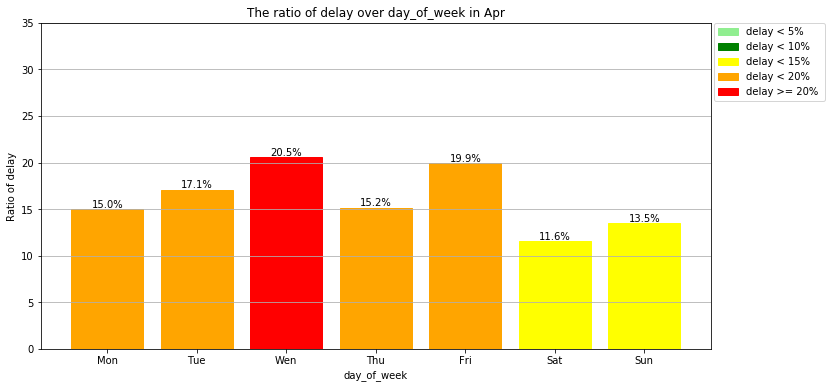

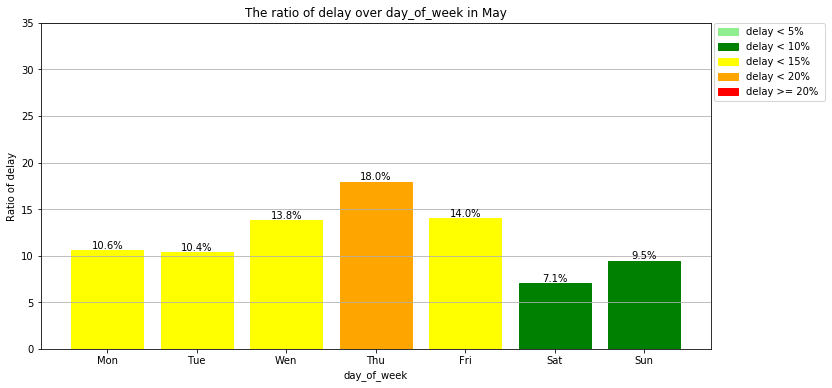

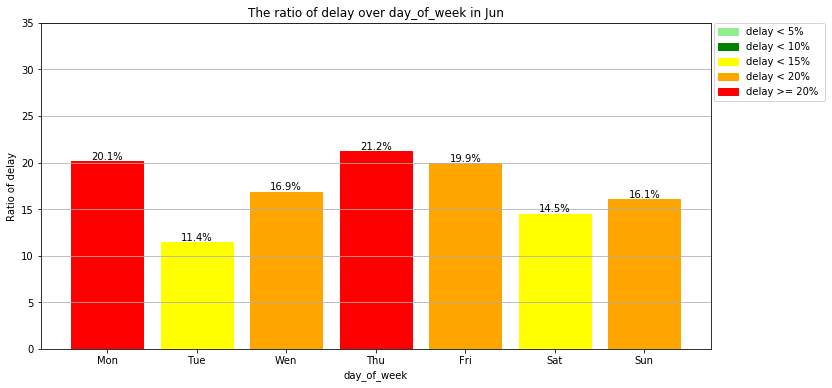

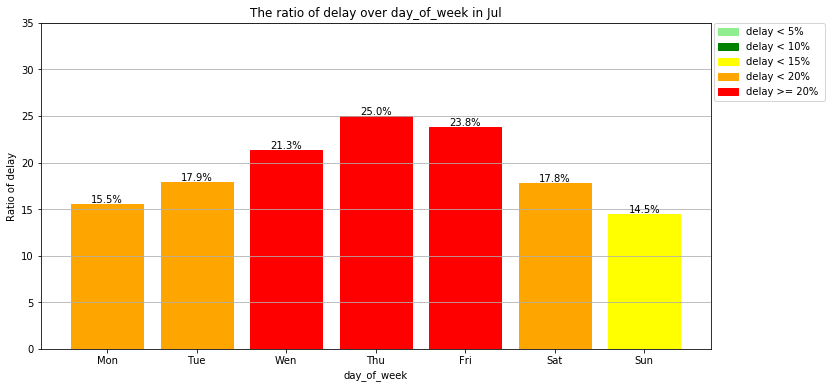

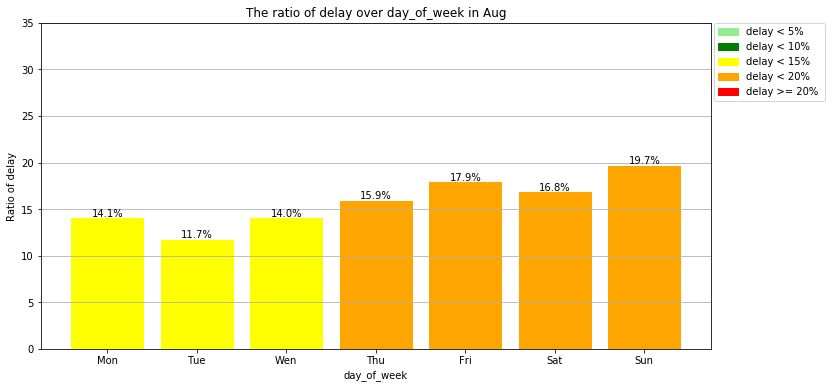

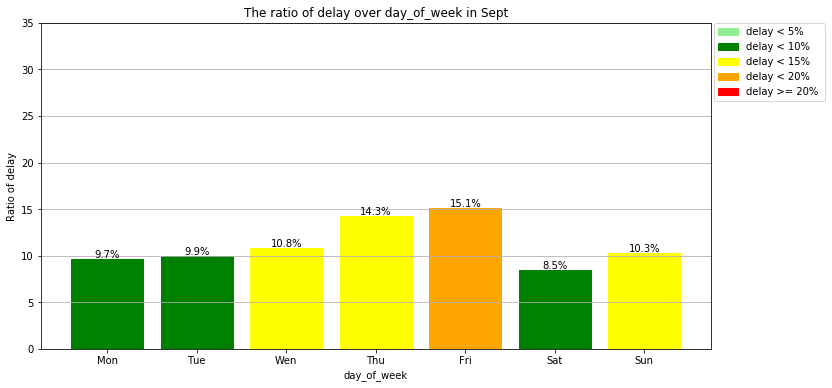

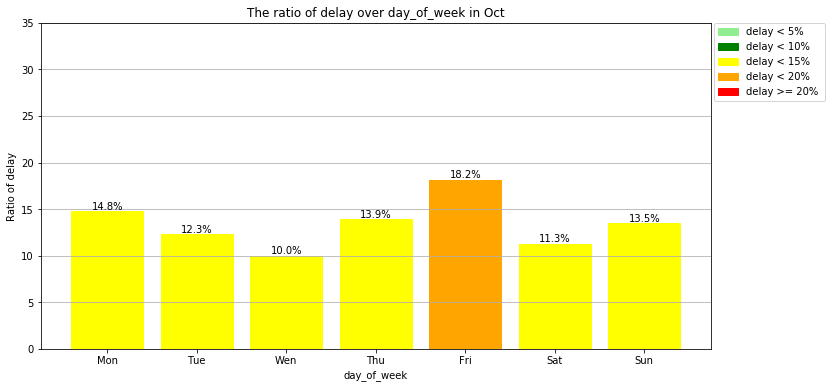

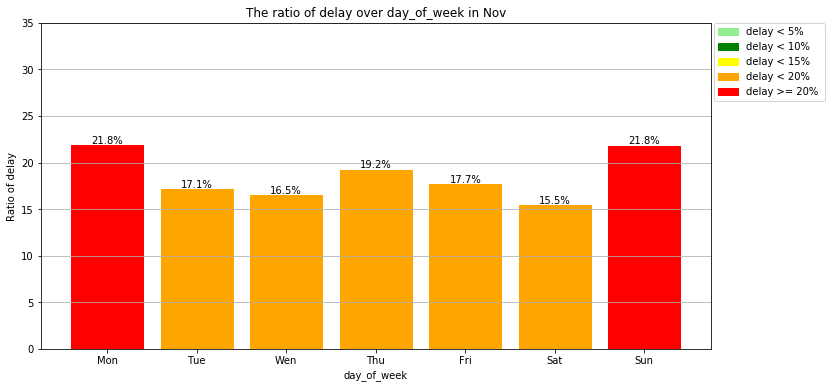

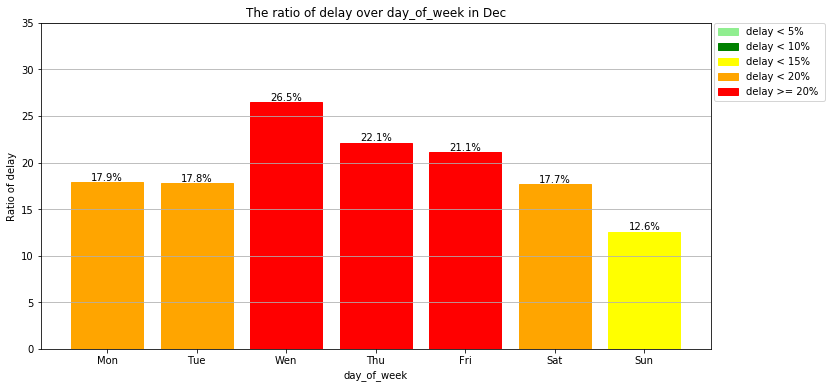

In [149]:
for i in range(1,13):
    pdf = pdf_week_percnt[pdf_week_percnt.month == i][['day_of_week','percentage']]
    
    plot_day_over_week(pdf, month[i-1], 'day_of_week')
    

**Answer:**

These plots are more representative of the reality. More precisely we can see that the first assumption: " the delay percentage of the flight over day_of_week is always lower than 20%" is completely wrong.

These plots are also in line with the previous (delay percentage over day_of_month). For instance, Jannuary is the month with the highest percentages also in this case.

I can also state that, in average, the weekend contains lower delay percentages which is reasonable since there are lower number of flights

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

In [101]:
df_hour_delay.show(5)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|hour|is_delay|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+----+--------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|   9|       0|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|   9|       1|
|1994|    1|          11|          2|                     900|  

In [227]:
df_delay_over_month = (
                         df_hour_delay
                                      .groupby('month').agg( (100 * func.sum('is_delay') / func.count('*') ).alias('percentage') )
                                      .orderBy('month', ascending=1)
                        )

df_delay_over_month.show(5)

+-----+------------------+
|month|        percentage|
+-----+------------------+
|    1|24.275411042771097|
|    2| 21.42347669232002|
|    3| 16.04280898979601|
|    4| 16.18879084074633|
|    5|11.835291637643437|
+-----+------------------+
only showing top 5 rows



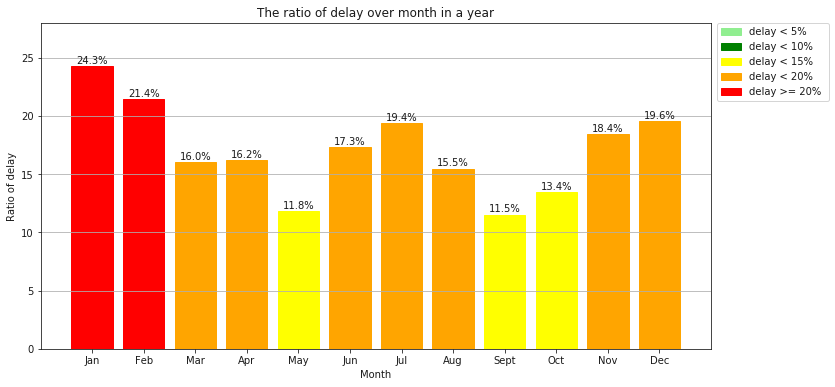

In [231]:
pdf = pd.DataFrame(data=df_delay_over_month.collect())

plt.figure(figsize=(12,6))

plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.title('The ratio of delay over month in a year')

plt.ylim(0, 28)
plt.xticks(range(13))

bars = plt.bar(month, pdf[1], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf[1][i] < 5:
        color = 'lightgreen'
    elif pdf[1][i] < 10:
        color = 'green'
    elif pdf[1][i] < 15:
        color = 'yellow'
    elif pdf[1][i] < 20:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 5%')
patch2 = mpatches.Patch(color='green', label='delay < 10%')
patch3 = mpatches.Patch(color='yellow', label='delay < 15% ')
patch4 = mpatches.Patch(color='orange', label='delay < 20% ')
patch5 = mpatches.Patch(color='red', label='delay >= 20% ')

ax1 = plt.gca()
ax1.grid(axis='y')
for p in ax1.patches:
    height = p.get_height()    # get bar length
    ax1.text(p.get_x() + p.get_width()/2, 
            height + .5 , 
            f'{height:1.1f}%', # set variable to display, 2 decimals
            ha = 'center',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

**Answer:**

The delays are different over month but the results are coherent with the previous plots. **Jan**, **Feb** are the worst month in terms of delay percentage flight.

We have no clue right now, but we can hypothesize that the **winter months** are characterized but poor climate condition which could be the explanation of the delayed flight 

The **summer months**, on the other side, may have better climate condition but probably it is present an higher air traffing condition due to the vacacions. 

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [152]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

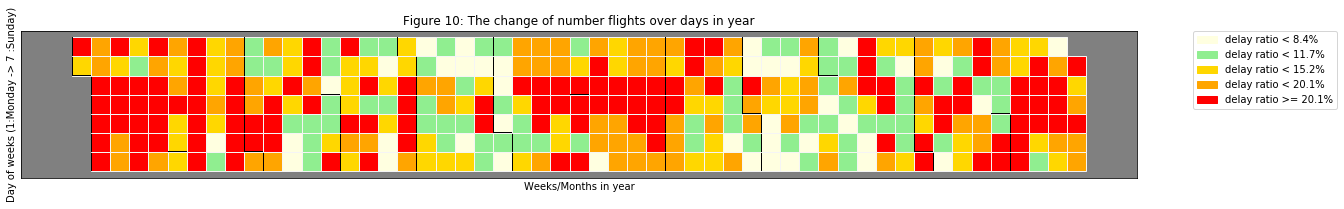

In [153]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [183]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [154]:
df.show(3)

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
only s

**ASSUMPTION**

Since for each flight there are two airports but one arrival delay, I did not know to which one associate the delay.

In order to get the statistics as general as posible, I have associated to both the delay 

In [163]:
src_delay = df.select('src_airport', 'arrival_delay')
dest_delay = df.select('dest_airport', 'arrival_delay')

airport_delay = src_delay.union(dest_delay)

airport_delay.count()

10360096

In [172]:
airport_delay_ratio = (airport_delay
                       
                         # consider only the busiest airoport 
                         .filter(airport_delay['src_airport'].isin(pdf_busiest_airport.airport.tolist()))
                        
                         # add 1 if it is delayed 0 otherwise
                         .withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
                         
                         # for each airport compute the probability to get delayed
                         .groupby('src_airport').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
                         
                         #change name for the join
                         .withColumnRenamed('src_airport', 'airport')
                       
                         # Order it for visualizing better
                         .orderBy('delay_ratio')
                                
                      )

airport_delay_ratio.show(5)


+-------+-------------------+
|airport|        delay_ratio|
+-------+-------------------+
|    MSP|0.13999112831679975|
|    DTW|0.14818729368158917|
|    ORD| 0.1556564035614228|
|    DCA|0.16124691252874543|
|    PHX|0.16685201026518393|
+-------+-------------------+
only showing top 5 rows



In [173]:
pdf_airport_delay_ratio = airport_delay_ratio.toPandas()

pdf_airport_delay_ratio.head()

,airport,delay_ratio
0,MSP,0.139991
1,DTW,0.148187
2,ORD,0.155656
3,DCA,0.161247
4,PHX,0.166852


In [193]:
pdf_busiest_airport.head(5)

,airport,SUM
0,ORD,561461.0
1,DFW,516523.0
2,ATL,443074.0
3,LAX,306453.0
4,STL,304409.0


In [195]:
pdf_total = pdf_busiest_airport.set_index('airport').join(pdf_airport_delay_ratio.set_index('airport'))
pdf_total.head()

,SUM,delay_ratio
airport,,
ORD,561461.0,0.155656
DFW,516523.0,0.202721
ATL,443074.0,0.208771
LAX,306453.0,0.185327
STL,304409.0,0.169548


In [196]:
pdf_total['tot_delay'] = pdf_total['SUM'] * pdf_total['delay_ratio']
pdf_total = pdf_total.reset_index()
pdf_total.head()

,airport,SUM,delay_ratio,tot_delay
0,ORD,561461.0,0.155656,87395.0
1,DFW,516523.0,0.202721,104710.0
2,ATL,443074.0,0.208771,92501.0
3,LAX,306453.0,0.185327,56794.0
4,STL,304409.0,0.169548,51612.0


In [206]:
pdf_total = pdf_total.sort_values('delay_ratio', ascending=False)
pdf_total.head()

,airport,SUM,delay_ratio,tot_delay
12,EWR,233991.0,0.261198,61118.0
15,BOS,199696.0,0.217220,43378.0
2,ATL,443074.0,0.208771,92501.0
17,PHL,186897.0,0.203262,37989.0
1,DFW,516523.0,0.202721,104710.0


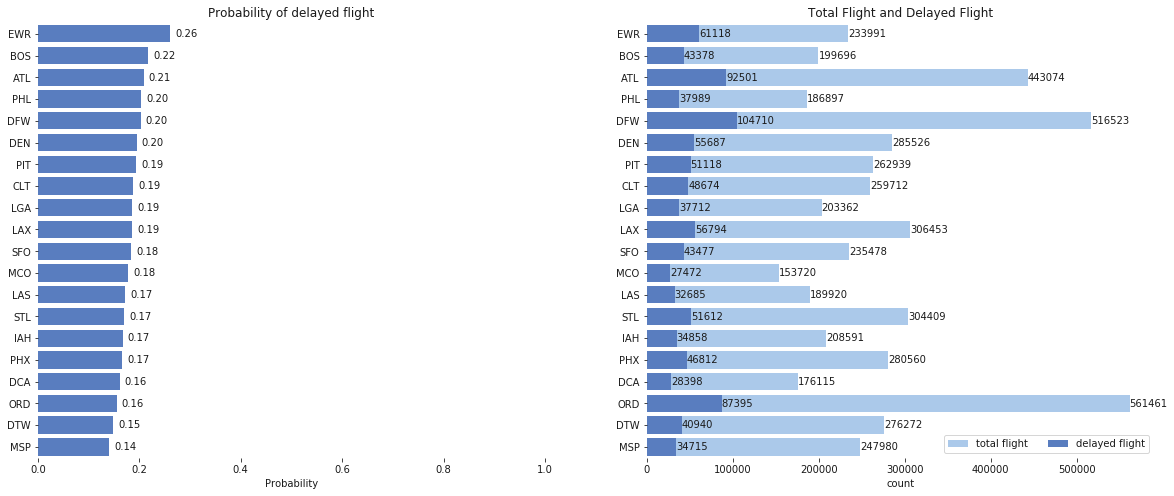

In [240]:
f, ax = plt.subplots(1,2, figsize=(20, 8))

#First Plot 
ax[0].title.set_text('Probability of delayed flight')
ax[0].grid(False)

sns.barplot(x="delay_ratio", y="airport", data=pdf_total, color='b',ax = ax[0])

ax[0].set(ylabel="",
          xlabel="Probability",
          xlim=(0,1) )

for p in ax[0].patches:
    width = p.get_width()    # get bar length
    ax[0].text(width+0.01,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

# Second Plot
 
ax[1].grid(False)
ax[1].title.set_text('Total Flight and Delayed Flight')

sns.set_color_codes("pastel")
sns.barplot(x="SUM", y="airport", data=pdf_total,
            label="total flight", color="b", ax = ax[1],)


sns.set_color_codes("muted")
splot = sns.barplot(x="tot_delay", y="airport", data=pdf_total,
            label="delayed flight", color="b", ax=ax[1])

ax[1].legend(ncol=2, loc="lower right", frameon=True)
ax[1].set(ylabel="",
       xlabel="count")
sns.despine(left=True, bottom=True)

for p in ax[1].patches:
    width = p.get_width()    # get bar length
    ax[1].text(width + 1.2,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment


**Answer:**

On the **left** is plotted the probability of delayed flight sorted for each of the 20 busiest airport


On the **right** is plotted the total num. of flights (light blue) and the num. of delayed flights (dark blue)


It is interesting to notice that the probability to get delayed flight is not directly correlated with the amount of flight which is a sort of logical contradiction but still possible.
For instance, if an airport is able to manage an higher number of flights, it is also able to manage the delayed one. Another explanation could be the position of the airport in the world (the influence of the weather)




### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [254]:
df.show()

+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|year|month|day_of_month|day_of_week|scheduled_departure_time|scheduled_arrival_time|arrival_delay|distance|src_airport|dest_airport|carrier|
+----+-----+------------+-----------+------------------------+----------------------+-------------+--------+-----------+------------+-------+
|1994|    1|           7|          5|                     900|                  1003|           -9|     290|        CLT|         ORF|     US|
|1994|    1|           8|          6|                     900|                  1003|          -11|     290|        CLT|         ORF|     US|
|1994|    1|          10|          1|                     900|                  1003|           20|     290|        CLT|         ORF|     US|
|1994|    1|          11|          2|                     900|                  1003|           88|     290|        CLT|         ORF|     US|
|1994|

In [243]:
busiest_carrier.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



In [255]:
carrer_delay_ratio = (df
                       
                         # consider only the busiest airoport 
                         .filter(df['carrier'].isin(busiest_carrier.toPandas().carrier.tolist()))
                        
                         # add 1 if it is delayed 0 otherwise
                         .withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
                         
                         # for each carrier compute the probability to get delayed
                         .groupby('carrier').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
                         
                         # Order it for visualizing better
                         .orderBy('delay_ratio')
                                
                      )

carrer_delay_ratio.show(5)

+-------+-------------------+
|carrier|        delay_ratio|
+-------+-------------------+
|     WN|0.12829795587751536|
|     NW| 0.1294806523639286|
|     AS| 0.1596424771227921|
|     UA| 0.1686528375733855|
|     AA| 0.1752444006939166|
+-------+-------------------+
only showing top 5 rows



In [262]:
pdf_total = carrer_delay_ratio.toPandas().set_index('carrier').join(busiest_carrier.toPandas().set_index('carrier'))
pdf_total.head()

,delay_ratio,count
carrier,,
WN,0.128298,565426
NW,0.129481,482798
AS,0.159642,117475
UA,0.168653,638750
AA,0.175244,722277


In [263]:
pdf_total['tot_delay'] = pdf_total['count'] * pdf_total['delay_ratio']
pdf_total = pdf_total.reset_index()

pdf_total.head()

,carrier,delay_ratio,count,tot_delay
0,WN,0.128298,565426,72543.0
1,NW,0.129481,482798,62513.0
2,AS,0.159642,117475,18754.0
3,UA,0.168653,638750,107727.0
4,AA,0.175244,722277,126575.0


In [264]:
pdf_total = pdf_total.sort_values('delay_ratio', ascending=False)
pdf_total.head()

,carrier,delay_ratio,count,tot_delay
9,CO,0.195558,484834,94813.0
8,HP,0.186251,177851,33125.0
7,US,0.184223,857906,158046.0
6,DL,0.183284,874526,160287.0
5,TW,0.182123,258205,47025.0


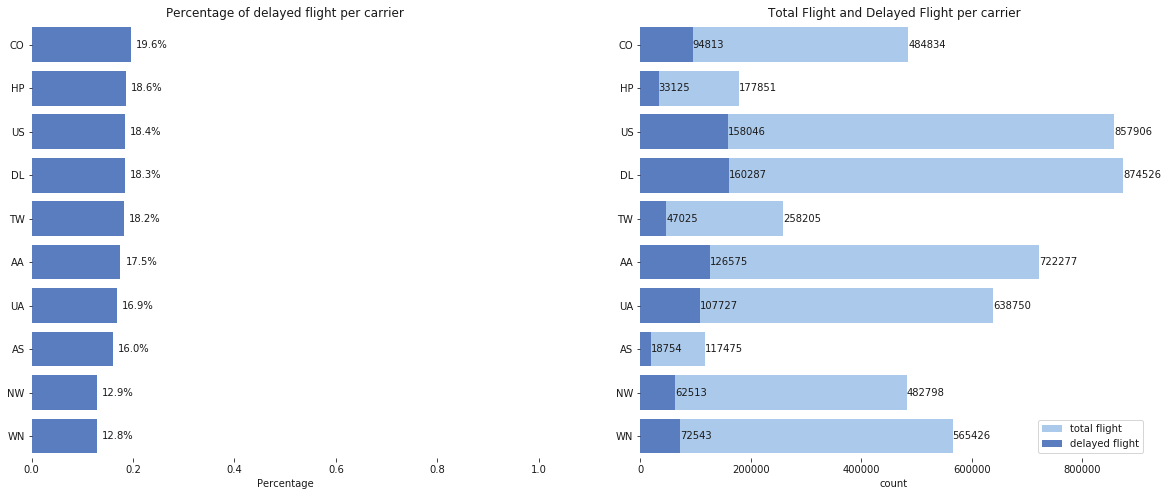

In [266]:
f, ax = plt.subplots(1,2, figsize=(20, 8))

#First Plot 
ax[0].title.set_text('Percentage of delayed flight per carrier')
ax[0].grid(False)

sns.barplot(x="delay_ratio", y="carrier", data=pdf_total, color='b',ax = ax[0])

ax[0].set(ylabel="",
          xlabel="Percentage",
          xlim=(0,1) )

for p in ax[0].patches:
    width = p.get_width()    # get bar length
    ax[0].text(width+0.01,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            f'{width*100:1.1f}%', # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

# Second Plot
 
ax[1].grid(False)
ax[1].title.set_text('Total Flight and Delayed Flight per carrier')

sns.set_color_codes("pastel")
sns.barplot(x="count", y="carrier", data=pdf_total,
            label="total flight", color="b", ax = ax[1],)


sns.set_color_codes("muted")
splot = sns.barplot(x="tot_delay", y="carrier", data=pdf_total,
            label="delayed flight", color="b", ax=ax[1])

ax[1].legend(ncol=1, loc="lower right", frameon=True)
ax[1].set(ylabel="",
       xlabel="count")
sns.despine(left=True, bottom=True)

for p in ax[1].patches:
    width = p.get_width()    # get bar length
    ax[1].text(width + 1.2,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment


**Answer:**

Also in this case, I cannot see a correlation between num. of flights per carrier and the delayed flight.

Indeed, the **CO** has the highest percentage of delayed flight but this carrier only has more or less 500 000 flights

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>


In [43]:
src_air = df.select('src_airport')

dst_air = df.select('dest_airport')

src_air.subtract(dst_air).show()

dst_air.subtract(src_air).show()

+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+

+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+



> **No arrivals** to **SPN** <br>
> **No departure** from **BFI** and **GUM**

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

In [44]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [53]:
airoport_probability = (df
                            .select("dest_airport", 'arrival_delay')
                            .withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
                            .groupby('dest_airport').agg((func.sum('is_delay')/func.count('*')).alias('probability'))
                            .orderBy(col('probability').desc())
                       )
airoport_probability.show(1)

+------------+-----------+
|dest_airport|probability|
+------------+-----------+
|         SPI|        0.5|
+------------+-----------+
only showing top 1 row



### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>